In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import optuna
from tqdm import tqdm
import yfinance as yf
from datetime import date, timedelta
import os

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

lookback = 60
horizon = 30
batch_size = 16
learning_rate = 0.001
num_epochs = 50
hidden_size = 128
num_stacked_layers = 3
dropout = 0.1
quantiles = [0.1, 0.5, 0.9]

Using device: cpu


In [23]:
def prepare_lstm_data(df, target_column="Price", lookback=60, horizon=30, scaler_type="robust"):
    df = df.copy()
    df.set_index("Date", inplace=True)
    df = df[[target_column]].copy()
    df[target_column] = df[target_column].shift(-horizon)

    for i in range(1, lookback + 1):
        df[f'{target_column}(t-{i})'] = df[target_column].shift(i)

    df.dropna(inplace=True)
    data_np = df.to_numpy()

    scaler = RobustScaler() if scaler_type == "robust" else MinMaxScaler(feature_range=(-1, 1))
    split_index = int(len(data_np) * 0.8)
    scaler.fit(data_np[:split_index])
    data_np = scaler.transform(data_np)

    X = np.flip(data_np[:, 1:], axis=1).copy()
    y = data_np[:, 0]

    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    X_train = X_train.reshape((-1, lookback, 1))
    X_test = X_test.reshape((-1, lookback, 1))
    y_train = y_train.reshape((-1, 1))
    y_test = y_test.reshape((-1, 1))

    return (torch.tensor(X_train).float(), torch.tensor(y_train).float(),
            torch.tensor(X_test).float(), torch.tensor(y_test).float(),
            scaler)

class TSData(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]
    
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i].unsqueeze(1)
        loss = torch.max((q - 1) * errors, q * errors)
        losses.append(torch.mean(loss))
    return torch.stack(losses).sum()

In [24]:
df_dict = {}
tickers = ["BTC-USD", "ETH-USD", "EURUSD=X"]

for ticker in tickers:
    df = yf.Ticker(ticker).history(period="1y", interval="1d")
    df.reset_index(inplace=True)
    df = df.iloc[::-1]
    df["Price"] = df["Close"].astype(float)
    
    df_dict[ticker] = df
    X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(df)

df_dict

{'BTC-USD':                          Date          Open          High           Low  \
 365 2025-04-15 00:00:00+00:00  84561.343750  85955.703125  84366.171875   
 364 2025-04-14 00:00:00+00:00  83694.523438  85785.000000  83690.640625   
 363 2025-04-13 00:00:00+00:00  85279.468750  86015.187500  83027.007812   
 362 2025-04-12 00:00:00+00:00  83404.515625  85856.187500  82769.375000   
 361 2025-04-11 00:00:00+00:00  79625.046875  84247.476562  78936.320312   
 ..                        ...           ...           ...           ...   
 4   2024-04-19 00:00:00+00:00  63510.750000  65481.597656  59651.390625   
 3   2024-04-18 00:00:00+00:00  61275.316406  64125.687500  60833.480469   
 2   2024-04-17 00:00:00+00:00  63831.847656  64486.363281  59768.585938   
 1   2024-04-16 00:00:00+00:00  63419.296875  64355.667969  61716.402344   
 0   2024-04-15 00:00:00+00:00  65739.648438  66878.648438  62332.070312   
 
             Close       Volume  Dividends  Stock Splits         Price  
 3

In [25]:
class QuantileLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, num_quantiles):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, num_quantiles)
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if "weight" in name and param.dim() > 1:
                nn.init.xavier_uniform_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.layer_norm(out[:, -1, :])
        return self.fc(out)

def inverse_transform(y_scaled, scaler, lookback):
    dummy = np.zeros((len(y_scaled), lookback + 1))
    dummy[:, 0] = y_scaled
    return scaler.inverse_transform(dummy)[:, 0]
def evaluate_quantile_predictions(model, X_train, y_train, X_test, y_test, scaler, lookback, ticker):
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train.to(device)).cpu().numpy()
        test_preds = model(X_test.to(device)).cpu().numpy()

    train_q50 = inverse_transform(train_preds[:, 1], scaler, lookback)
    train_actual = inverse_transform(y_train.cpu().numpy().flatten(), scaler, lookback)
    
    test_q10 = inverse_transform(test_preds[:, 0], scaler, lookback)
    test_q50 = inverse_transform(test_preds[:, 1], scaler, lookback)
    test_q90 = inverse_transform(test_preds[:, 2], scaler, lookback)
    test_actual = inverse_transform(y_test.cpu().numpy().flatten(), scaler, lookback)

    plt.figure(figsize=(15, 6))
    plt.plot(train_actual, label="Training Actual", color="black")
    plt.plot(train_q50, label="Training Predictions", color="blue")
    plt.title(f"Training Data: Predictions vs Actual")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(test_actual, label="Test Actual", color="black")
    plt.plot(test_q50, label="Test Predictions", color="blue")
    plt.fill_between(range(len(test_actual)), test_q10, test_q90, color="gray", alpha=0.3, 
                    label="80% Prediction Interval")
    plt.title(f"Test Data: {ticker} — Predictions vs Actual ({horizon}-day ahead)")

    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mae = np.mean(np.abs(test_actual - test_q50))
    rmse = np.sqrt(np.mean((test_actual - test_q50)**2))
    mape = np.mean(np.abs((test_actual - test_q50) / test_actual)) * 100
    
    print(f"\nTest Set Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    return {
        "train_actual": train_actual,
        "train_pred": train_q50,
        "test_actual": test_actual,
        "test_q10": test_q10,
        "test_q50": test_q50,
        "test_q90": test_q90
    }

def forecast_next_days(model, X_last_window, scaler, lookback, horizon, quantiles):
    model.eval()
    preds_q10, preds_q50, preds_q90 = [], [], []

    current_input = X_last_window.clone().to(device)

    for _ in range(horizon):
        with torch.no_grad():
            out = model(current_input)
            q10, q50, q90 = out[0].cpu().numpy()
            preds_q10.append(q10)
            preds_q50.append(q50)
            preds_q90.append(q90)

        next_step = q50 + np.random.normal(0, abs(q90 - q10) / 4)
        next_step_tensor = torch.tensor([[[next_step]]], dtype=torch.float32).to(device)
        current_input = torch.cat([current_input[:, 1:, :], next_step_tensor], dim=1)

    def inv(preds_scaled):
        dummy = np.zeros((len(preds_scaled), lookback + 1))
        dummy[:, 0] = preds_scaled
        return scaler.inverse_transform(dummy)[:, 0]

    return {
        "q10": inv(preds_q10),
        "q50": inv(preds_q50),
        "q90": inv(preds_q90)
    }

def plot_forecast(forecast_dict, ticker, last_actual=None):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    sns.set(style="whitegrid", rc={"grid.linewidth": 0.5, "grid.alpha": 0.5})
    sns.set_context("notebook", font_scale=1.2)
    
    q10 = forecast_dict["q10"]
    q50 = forecast_dict["q50"]
    q90 = forecast_dict["q90"]
    
    df = pd.DataFrame({
        'Day': range(len(q50)),
        'Lower Bound (q10)': q10,
        'Median Forecast (q50)': q50,
        'Upper Bound (q90)': q90
    })
    
    plt.figure(figsize=(15, 8))
    
    ax = plt.gca()
    ax.fill_between(df['Day'], df['Lower Bound (q10)'], df['Upper Bound (q90)'], 
                    color='lightsteelblue', alpha=0.5, label='80% Prediction Interval')
    
    sns.lineplot(data=df, x='Day', y='Median Forecast (q50)', 
                 color='royalblue', linewidth=3, label='Median Forecast (q50)')
    sns.lineplot(data=df, x='Day', y='Lower Bound (q10)', 
                 color='crimson', linewidth=1.5, linestyle='--', label='Lower Bound (q10)')
    sns.lineplot(data=df, x='Day', y='Upper Bound (q90)', 
                 color='forestgreen', linewidth=1.5, linestyle='--', label='Upper Bound (q90)')
    
    plt.scatter(df['Day'], df['Median Forecast (q50)'], color='royalblue', s=40, zorder=5)
    
    pct_change = ((q50[-1] - q50[0]) / q50[0] * 100)
    change_direction = "↑" if pct_change > 0 else "↓"
    change_color = "green" if pct_change > 0 else "red"
    
    plt.annotate(f"${q50[0]:,.2f}", (0, q50[0]), xytext=(-10, -20), 
                textcoords='offset points', fontweight='bold')
    plt.annotate(f"${q50[-1]:,.2f} ({change_direction}{abs(pct_change):.1f}%)", 
                (len(q50)-1, q50[-1]), xytext=(10, 10), 
                textcoords='offset points', fontweight='bold', color=change_color)
    
    plt.title(f"{horizon}-Day {ticker} Price Forecast", fontsize=16, fontweight='bold', pad=20)

    plt.xlabel("Days Ahead", fontsize=12)
    plt.ylabel("Price ($)", fontsize=12)
    plt.yscale('log')

    plt.legend(loc='upper left', frameon=True, framealpha=0.9)
    
    plt.tight_layout()
    plt.show()


In [26]:
def train_model(model, train_loader, optimizer, num_epochs, device, ticker=""):
    loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        
        loop = tqdm(train_loader, desc=f"[{ticker}] Epoch {epoch+1}/{num_epochs}")

        for xb, yb in loop:
            xb, yb = xb.to(device), yb.to(device)
            
            preds = model(xb)
            loss = quantile_loss(preds, yb, quantiles)
            
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            
            loop.set_postfix(loss=loss.item())
        
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        
        print(f"[Epoch {epoch+1}/{num_epochs}] Training Loss: {avg_loss:.6f}")
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")
    
    plt.figure(figsize=(12, 5))
    plt.plot(loss_history)
    plt.title(f"Training Loss History — {ticker}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTraining completed! Final loss: {loss_history[-1]:.6f}")
    return model

def objective(trial, df):
    lookback = trial.suggest_int("lookback", 30, 90, step=10)
    hidden_size = trial.suggest_int("hidden_size", 64, 256, step=32)
    num_stacked_layers = trial.suggest_int("num_layers", 1, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    
    print(f"\nTrial #{trial.number}:")
    print(f"  lookback: {lookback}, hidden_size: {hidden_size}, num_layers: {num_stacked_layers}")
    print(f"  dropout: {dropout}, learning_rate: {learning_rate}, batch_size: {batch_size}")
    
    X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(
        df, lookback=lookback, horizon=horizon, scaler_type="robust"
    )
    
    val_size = int(len(X_train) * 0.2)
    X_val, y_val = X_train[-val_size:], y_train[-val_size:]
    X_train, y_train = X_train[:-val_size], y_train[:-val_size]
    
    train_dataset = TSData(X_train, y_train)
    val_dataset = TSData(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = QuantileLSTM(
        input_size=1,
        hidden_size=hidden_size,
        num_layers=num_stacked_layers,
        dropout=dropout,
        num_quantiles=len(quantiles)
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(15):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = quantile_loss(preds, yb, quantiles)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += quantile_loss(preds, yb, quantiles).item()
        
        val_loss /= len(val_loader)
        
        print(f"    Epoch {epoch+1}/15 - Validation Loss: {val_loss:.6f}" + 
              (f" (best)" if val_loss < best_val_loss else ""))
        
        trial.report(val_loss, epoch)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"    Early stopping at epoch {epoch+1}")
            break
            
        if trial.should_prune():
            print(f"    Trial pruned at epoch {epoch+1}")
            raise optuna.exceptions.TrialPruned()
    
    print(f"  Final validation loss: {best_val_loss:.6f}")
    return best_val_loss

def run_hyperparameter_optimization(df, ticker, n_trials=50):
    print("\n" + "="*50)
    print("STARTING HYPERPARAMETER OPTIMIZATION")
    print("="*50)
    print(f"Number of trials: {n_trials}")
    print("Parameters being optimized:")
    print("  - lookback window (30-90 days)")
    print("  - hidden size (64-256 neurons)")
    print("  - number of LSTM layers (1-5)")
    print("  - dropout rate (0.0-0.5)")
    print("  - learning rate (1e-4 to 1e-2)")
    print("  - batch size (8, 16, 32, 64)")
    print("="*50 + "\n")
    
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, df), n_trials=n_trials)
    
    print("\n" + "="*50)
    print("OPTIMIZATION RESULTS")
    print("="*50)
    print(f"Best trial: #{study.best_trial.number}")
    print(f"Best validation loss: {study.best_trial.value:.6f}")
    print("\nBest hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"  - {key}: {value}")
    print("="*50)
    
    try:
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.show()
        
        fig2 = optuna.visualization.plot_param_importances(study)
        fig2.show()
        
        fig3 = optuna.visualization.plot_contour(study)
        fig3.show()
    except Exception as e:
        print(f"Unable to display Optuna visualization: {str(e)}")
    
    return study.best_params

In [29]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



🏁 Running pipeline for BTC-USD


[I 2025-04-15 17:19:55,997] A new study created in memory with name: no-name-37a5e5fb-2c97-4688-97d5-bee62fc85121


📁 Saved historical data to: C:\Users\Chico\OneDrive\Ambiente de Trabalho\Quant LSTM\yf data\BTC-USD.csv

STARTING HYPERPARAMETER OPTIMIZATION
Number of trials: 20
Parameters being optimized:
  - lookback window (30-90 days)
  - hidden size (64-256 neurons)
  - number of LSTM layers (1-5)
  - dropout rate (0.0-0.5)
  - learning rate (1e-4 to 1e-2)
  - batch size (8, 16, 32, 64)


Trial #0:
  lookback: 30, hidden_size: 192, num_layers: 2
  dropout: 0.4, learning_rate: 0.00016582321073970932, batch_size: 64
    Epoch 1/15 - Validation Loss: 0.267365 (best)
    Epoch 2/15 - Validation Loss: 0.340162
    Epoch 3/15 - Validation Loss: 0.339689
    Epoch 4/15 - Validation Loss: 0.313304


[I 2025-04-15 17:19:57,070] Trial 0 finished with value: 0.2673652470111847 and parameters: {'lookback': 30, 'hidden_size': 192, 'num_layers': 2, 'dropout': 0.4, 'learning_rate': 0.00016582321073970932, 'batch_size': 64}. Best is trial 0 with value: 0.2673652470111847.


    Epoch 5/15 - Validation Loss: 0.267800
    Epoch 6/15 - Validation Loss: 0.284516
    Early stopping at epoch 6
  Final validation loss: 0.267365

Trial #1:
  lookback: 60, hidden_size: 128, num_layers: 1
  dropout: 0.0, learning_rate: 0.00017945257148275923, batch_size: 64
    Epoch 1/15 - Validation Loss: 1.106274 (best)
    Epoch 2/15 - Validation Loss: 0.781532 (best)
    Epoch 3/15 - Validation Loss: 0.747575 (best)
    Epoch 4/15 - Validation Loss: 0.764920
    Epoch 5/15 - Validation Loss: 0.774845
    Epoch 6/15 - Validation Loss: 0.757662
    Epoch 7/15 - Validation Loss: 0.758172
    Epoch 8/15 - Validation Loss: 0.728209 (best)
    Epoch 9/15 - Validation Loss: 0.653770 (best)
    Epoch 10/15 - Validation Loss: 0.549287 (best)
    Epoch 11/15 - Validation Loss: 0.493855 (best)


[I 2025-04-15 17:19:58,174] Trial 1 finished with value: 0.30329155921936035 and parameters: {'lookback': 60, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.00017945257148275923, 'batch_size': 64}. Best is trial 0 with value: 0.2673652470111847.


    Epoch 12/15 - Validation Loss: 0.417566 (best)
    Epoch 13/15 - Validation Loss: 0.344595 (best)
    Epoch 14/15 - Validation Loss: 0.307326 (best)
    Epoch 15/15 - Validation Loss: 0.303292 (best)
  Final validation loss: 0.303292

Trial #2:
  lookback: 60, hidden_size: 160, num_layers: 3
  dropout: 0.1, learning_rate: 0.007734516875453123, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.400115 (best)
    Epoch 2/15 - Validation Loss: 0.305831 (best)
    Epoch 3/15 - Validation Loss: 0.091665 (best)
    Epoch 4/15 - Validation Loss: 0.158837
    Epoch 5/15 - Validation Loss: 0.260724
    Epoch 6/15 - Validation Loss: 0.207080
    Epoch 7/15 - Validation Loss: 0.160844


[I 2025-04-15 17:20:02,455] Trial 2 finished with value: 0.09166483022272587 and parameters: {'lookback': 60, 'hidden_size': 160, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.007734516875453123, 'batch_size': 8}. Best is trial 2 with value: 0.09166483022272587.


    Epoch 8/15 - Validation Loss: 0.139969
    Early stopping at epoch 8
  Final validation loss: 0.091665

Trial #3:
  lookback: 60, hidden_size: 64, num_layers: 3
  dropout: 0.1, learning_rate: 0.00031279422658130984, batch_size: 64
    Epoch 1/15 - Validation Loss: 0.446507 (best)
    Epoch 2/15 - Validation Loss: 0.426587 (best)
    Epoch 3/15 - Validation Loss: 0.370864 (best)
    Epoch 4/15 - Validation Loss: 0.289198 (best)
    Epoch 5/15 - Validation Loss: 0.194150 (best)
    Epoch 6/15 - Validation Loss: 0.207360
    Epoch 7/15 - Validation Loss: 0.184180 (best)
    Epoch 8/15 - Validation Loss: 0.160923 (best)
    Epoch 9/15 - Validation Loss: 0.137015 (best)
    Epoch 10/15 - Validation Loss: 0.119920 (best)
    Epoch 11/15 - Validation Loss: 0.123512
    Epoch 12/15 - Validation Loss: 0.121780
    Epoch 13/15 - Validation Loss: 0.142076


[I 2025-04-15 17:20:03,787] Trial 3 finished with value: 0.11749811470508575 and parameters: {'lookback': 60, 'hidden_size': 64, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.00031279422658130984, 'batch_size': 64}. Best is trial 2 with value: 0.09166483022272587.


    Epoch 14/15 - Validation Loss: 0.145244
    Epoch 15/15 - Validation Loss: 0.117498 (best)
  Final validation loss: 0.117498

Trial #4:
  lookback: 50, hidden_size: 192, num_layers: 3
  dropout: 0.1, learning_rate: 0.007638741657841321, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.757557 (best)
    Epoch 2/15 - Validation Loss: 0.640564 (best)
    Epoch 3/15 - Validation Loss: 0.228675 (best)
    Epoch 4/15 - Validation Loss: 0.298589
    Epoch 5/15 - Validation Loss: 0.217596 (best)
    Epoch 6/15 - Validation Loss: 0.270145
    Epoch 7/15 - Validation Loss: 0.289406
    Epoch 8/15 - Validation Loss: 0.211612 (best)
    Epoch 9/15 - Validation Loss: 0.269400
    Epoch 10/15 - Validation Loss: 0.186634 (best)
    Epoch 11/15 - Validation Loss: 0.408512
    Epoch 12/15 - Validation Loss: 0.193081
    Epoch 13/15 - Validation Loss: 0.240365
    Epoch 14/15 - Validation Loss: 0.317698


[I 2025-04-15 17:20:13,642] Trial 4 finished with value: 0.18663431952397028 and parameters: {'lookback': 50, 'hidden_size': 192, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.007638741657841321, 'batch_size': 8}. Best is trial 2 with value: 0.09166483022272587.


    Epoch 15/15 - Validation Loss: 0.424791
    Early stopping at epoch 15
  Final validation loss: 0.186634

Trial #5:
  lookback: 30, hidden_size: 160, num_layers: 3
  dropout: 0.2, learning_rate: 0.004643871463958648, batch_size: 16
    Epoch 1/15 - Validation Loss: 0.208039 (best)
    Epoch 2/15 - Validation Loss: 0.593256
    Epoch 3/15 - Validation Loss: 0.215114
    Epoch 4/15 - Validation Loss: 0.320599
    Epoch 5/15 - Validation Loss: 0.134458 (best)
    Epoch 6/15 - Validation Loss: 0.084557 (best)
    Epoch 7/15 - Validation Loss: 0.063394 (best)
    Epoch 8/15 - Validation Loss: 0.162424
    Epoch 9/15 - Validation Loss: 0.099063
    Epoch 10/15 - Validation Loss: 0.134821
    Epoch 11/15 - Validation Loss: 0.099517
    Epoch 12/15 - Validation Loss: 0.051646 (best)
    Epoch 13/15 - Validation Loss: 0.124438
    Epoch 14/15 - Validation Loss: 0.078798


[I 2025-04-15 17:20:18,875] Trial 5 finished with value: 0.05164578805367152 and parameters: {'lookback': 30, 'hidden_size': 160, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.004643871463958648, 'batch_size': 16}. Best is trial 5 with value: 0.05164578805367152.


    Epoch 15/15 - Validation Loss: 0.070865
  Final validation loss: 0.051646

Trial #6:
  lookback: 40, hidden_size: 128, num_layers: 3
  dropout: 0.0, learning_rate: 0.00042356270567515876, batch_size: 32


[I 2025-04-15 17:20:19,119] Trial 6 pruned. 
c:\Users\Chico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
[I 2025-04-15 17:20:19,259] Trial 7 pruned. 


    Epoch 1/15 - Validation Loss: 1.206452 (best)
    Trial pruned at epoch 1

Trial #7:
  lookback: 80, hidden_size: 96, num_layers: 1
  dropout: 0.2, learning_rate: 0.0003193127066347343, batch_size: 32
    Epoch 1/15 - Validation Loss: 0.433178 (best)
    Trial pruned at epoch 1

Trial #8:
  lookback: 70, hidden_size: 192, num_layers: 1
  dropout: 0.1, learning_rate: 0.0019312492085370194, batch_size: 8


c:\Users\Chico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
[I 2025-04-15 17:20:19,592] Trial 8 pruned. 
[I 2025-04-15 17:20:19,701] Trial 9 pruned. 


    Epoch 1/15 - Validation Loss: 0.629746 (best)
    Trial pruned at epoch 1

Trial #9:
  lookback: 50, hidden_size: 64, num_layers: 2
  dropout: 0.2, learning_rate: 0.0005336321677555749, batch_size: 64
    Epoch 1/15 - Validation Loss: 0.649846 (best)
    Trial pruned at epoch 1

Trial #10:
  lookback: 90, hidden_size: 256, num_layers: 5
  dropout: 0.5, learning_rate: 0.0024507648060822355, batch_size: 16


[I 2025-04-15 17:20:21,770] Trial 10 pruned. 


    Epoch 1/15 - Validation Loss: 0.819694 (best)
    Trial pruned at epoch 1

Trial #11:
  lookback: 30, hidden_size: 160, num_layers: 5
  dropout: 0.30000000000000004, learning_rate: 0.007465677951023807, batch_size: 16


[I 2025-04-15 17:20:22,362] Trial 11 pruned. 


    Epoch 1/15 - Validation Loss: 0.867120 (best)
    Trial pruned at epoch 1

Trial #12:
  lookback: 40, hidden_size: 224, num_layers: 4
  dropout: 0.30000000000000004, learning_rate: 0.003340994090412576, batch_size: 8


[I 2025-04-15 17:20:23,452] Trial 12 pruned. 


    Epoch 1/15 - Validation Loss: 0.622564 (best)
    Trial pruned at epoch 1

Trial #13:
  lookback: 70, hidden_size: 160, num_layers: 4
  dropout: 0.2, learning_rate: 0.00455875258119716, batch_size: 16


[I 2025-04-15 17:20:24,225] Trial 13 pruned. 


    Epoch 1/15 - Validation Loss: 0.818457 (best)
    Trial pruned at epoch 1

Trial #14:
  lookback: 40, hidden_size: 128, num_layers: 4
  dropout: 0.1, learning_rate: 0.0012077778089250397, batch_size: 16


[I 2025-04-15 17:20:24,787] Trial 14 pruned. 


    Epoch 1/15 - Validation Loss: 0.745439 (best)
    Trial pruned at epoch 1

Trial #15:
  lookback: 90, hidden_size: 160, num_layers: 2
  dropout: 0.30000000000000004, learning_rate: 0.005183917020227165, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.391443 (best)
    Epoch 2/15 - Validation Loss: 0.345818 (best)


[I 2025-04-15 17:20:26,618] Trial 15 pruned. 


    Epoch 3/15 - Validation Loss: 0.286578 (best)
    Trial pruned at epoch 3

Trial #16:
  lookback: 50, hidden_size: 224, num_layers: 4
  dropout: 0.0, learning_rate: 0.009762345986420283, batch_size: 16


[I 2025-04-15 17:20:27,553] Trial 16 pruned. 


    Epoch 1/15 - Validation Loss: 0.557771 (best)
    Trial pruned at epoch 1

Trial #17:
  lookback: 70, hidden_size: 96, num_layers: 2
  dropout: 0.4, learning_rate: 0.0013430114910176075, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.133163 (best)
    Epoch 2/15 - Validation Loss: 0.145285
    Epoch 3/15 - Validation Loss: 0.104468 (best)
    Epoch 4/15 - Validation Loss: 0.075510 (best)
    Epoch 5/15 - Validation Loss: 0.111346
    Epoch 6/15 - Validation Loss: 0.102754
    Epoch 7/15 - Validation Loss: 0.055278 (best)
    Epoch 8/15 - Validation Loss: 0.117140
    Epoch 9/15 - Validation Loss: 0.146415
    Epoch 10/15 - Validation Loss: 0.076586
    Epoch 11/15 - Validation Loss: 0.065768


[I 2025-04-15 17:20:33,456] Trial 17 finished with value: 0.055277517065405846 and parameters: {'lookback': 70, 'hidden_size': 96, 'num_layers': 2, 'dropout': 0.4, 'learning_rate': 0.0013430114910176075, 'batch_size': 8}. Best is trial 5 with value: 0.05164578805367152.


    Epoch 12/15 - Validation Loss: 0.066933
    Early stopping at epoch 12
  Final validation loss: 0.055278

Trial #18:
  lookback: 70, hidden_size: 96, num_layers: 2
  dropout: 0.5, learning_rate: 0.0011711263083938595, batch_size: 32


[I 2025-04-15 17:20:33,741] Trial 18 pruned. 


    Epoch 1/15 - Validation Loss: 1.067956 (best)
    Trial pruned at epoch 1

Trial #19:
  lookback: 80, hidden_size: 96, num_layers: 2
  dropout: 0.4, learning_rate: 0.000855896013550753, batch_size: 16


[I 2025-04-15 17:20:34,314] Trial 19 pruned. 


    Epoch 1/15 - Validation Loss: 0.614989 (best)
    Trial pruned at epoch 1

OPTIMIZATION RESULTS
Best trial: #5
Best validation loss: 0.051646

Best hyperparameters:
  - lookback: 30
  - hidden_size: 160
  - num_layers: 3
  - dropout: 0.2
  - learning_rate: 0.004643871463958648
  - batch_size: 16
Unable to display Optuna visualization: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.


[BTC-USD] Epoch 1/50: 100%|██████████| 16/16 [00:00<00:00, 36.00it/s, loss=0.423]


[Epoch 1/50] Training Loss: 1.549186
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 2/50: 100%|██████████| 16/16 [00:00<00:00, 23.27it/s, loss=0.198]


[Epoch 2/50] Training Loss: 0.383404
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 3/50: 100%|██████████| 16/16 [00:00<00:00, 37.20it/s, loss=0.183]


[Epoch 3/50] Training Loss: 0.173776
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 4/50: 100%|██████████| 16/16 [00:00<00:00, 36.14it/s, loss=0.189]


[Epoch 4/50] Training Loss: 0.166791
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 5/50: 100%|██████████| 16/16 [00:00<00:00, 36.53it/s, loss=0.17] 


[Epoch 5/50] Training Loss: 0.143774
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 6/50: 100%|██████████| 16/16 [00:00<00:00, 36.74it/s, loss=0.176] 


[Epoch 6/50] Training Loss: 0.127404
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 7/50: 100%|██████████| 16/16 [00:00<00:00, 32.72it/s, loss=0.115]


[Epoch 7/50] Training Loss: 0.160810
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 8/50: 100%|██████████| 16/16 [00:00<00:00, 36.56it/s, loss=0.098] 


[Epoch 8/50] Training Loss: 0.127553
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 9/50: 100%|██████████| 16/16 [00:00<00:00, 36.51it/s, loss=0.0809]


[Epoch 9/50] Training Loss: 0.091805
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 10/50: 100%|██████████| 16/16 [00:00<00:00, 37.07it/s, loss=0.119]


[Epoch 10/50] Training Loss: 0.138126
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 11/50: 100%|██████████| 16/16 [00:00<00:00, 36.16it/s, loss=0.125] 


[Epoch 11/50] Training Loss: 0.106208
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 12/50: 100%|██████████| 16/16 [00:00<00:00, 36.09it/s, loss=0.0741]


[Epoch 12/50] Training Loss: 0.079853
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 13/50: 100%|██████████| 16/16 [00:00<00:00, 31.79it/s, loss=0.0475]


[Epoch 13/50] Training Loss: 0.086583
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 14/50: 100%|██████████| 16/16 [00:00<00:00, 36.87it/s, loss=0.0971]


[Epoch 14/50] Training Loss: 0.098618
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 15/50: 100%|██████████| 16/16 [00:00<00:00, 36.00it/s, loss=0.15]  


[Epoch 15/50] Training Loss: 0.112263
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 16/50: 100%|██████████| 16/16 [00:00<00:00, 37.02it/s, loss=0.075] 


[Epoch 16/50] Training Loss: 0.081921
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 17/50: 100%|██████████| 16/16 [00:00<00:00, 36.85it/s, loss=0.0593]


[Epoch 17/50] Training Loss: 0.076538
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 18/50: 100%|██████████| 16/16 [00:00<00:00, 37.40it/s, loss=0.0582]


[Epoch 18/50] Training Loss: 0.077286
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 19/50: 100%|██████████| 16/16 [00:00<00:00, 32.96it/s, loss=0.0961]


[Epoch 19/50] Training Loss: 0.092297
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 20/50: 100%|██████████| 16/16 [00:00<00:00, 36.59it/s, loss=0.169]


[Epoch 20/50] Training Loss: 0.118959
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 21/50: 100%|██████████| 16/16 [00:00<00:00, 25.84it/s, loss=0.0737]


[Epoch 21/50] Training Loss: 0.119624
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 22/50: 100%|██████████| 16/16 [00:00<00:00, 31.43it/s, loss=0.191] 


[Epoch 22/50] Training Loss: 0.100220
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 23/50: 100%|██████████| 16/16 [00:00<00:00, 36.87it/s, loss=0.0817]


[Epoch 23/50] Training Loss: 0.077575
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 24/50: 100%|██████████| 16/16 [00:00<00:00, 36.39it/s, loss=0.078] 


[Epoch 24/50] Training Loss: 0.074785
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 25/50: 100%|██████████| 16/16 [00:00<00:00, 32.82it/s, loss=0.16]  


[Epoch 25/50] Training Loss: 0.128793
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 26/50: 100%|██████████| 16/16 [00:00<00:00, 37.06it/s, loss=0.0644]


[Epoch 26/50] Training Loss: 0.086998
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 27/50: 100%|██████████| 16/16 [00:00<00:00, 36.90it/s, loss=0.0926]


[Epoch 27/50] Training Loss: 0.090292
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 28/50: 100%|██████████| 16/16 [00:00<00:00, 36.62it/s, loss=0.0578]


[Epoch 28/50] Training Loss: 0.081439
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 29/50: 100%|██████████| 16/16 [00:00<00:00, 37.12it/s, loss=0.111] 


[Epoch 29/50] Training Loss: 0.071591
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 30/50: 100%|██████████| 16/16 [00:00<00:00, 32.56it/s, loss=0.0652]


[Epoch 30/50] Training Loss: 0.075806
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 31/50: 100%|██████████| 16/16 [00:00<00:00, 37.07it/s, loss=0.0923]


[Epoch 31/50] Training Loss: 0.105494
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 32/50: 100%|██████████| 16/16 [00:00<00:00, 36.70it/s, loss=0.0481]


[Epoch 32/50] Training Loss: 0.076988
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 33/50: 100%|██████████| 16/16 [00:00<00:00, 35.46it/s, loss=0.09]  


[Epoch 33/50] Training Loss: 0.085703
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 34/50: 100%|██████████| 16/16 [00:00<00:00, 33.96it/s, loss=0.084] 


[Epoch 34/50] Training Loss: 0.072090
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 35/50: 100%|██████████| 16/16 [00:00<00:00, 23.12it/s, loss=0.107] 


[Epoch 35/50] Training Loss: 0.081067
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 36/50: 100%|██████████| 16/16 [00:00<00:00, 31.52it/s, loss=0.0583]


[Epoch 36/50] Training Loss: 0.113928
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 37/50: 100%|██████████| 16/16 [00:00<00:00, 23.17it/s, loss=0.0402]


[Epoch 37/50] Training Loss: 0.070857
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 38/50: 100%|██████████| 16/16 [00:00<00:00, 21.96it/s, loss=0.09]  


[Epoch 38/50] Training Loss: 0.078779
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 39/50: 100%|██████████| 16/16 [00:00<00:00, 36.11it/s, loss=0.0664]


[Epoch 39/50] Training Loss: 0.078761
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 40/50: 100%|██████████| 16/16 [00:00<00:00, 23.90it/s, loss=0.0556]


[Epoch 40/50] Training Loss: 0.066972
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 41/50: 100%|██████████| 16/16 [00:00<00:00, 36.99it/s, loss=0.13]  


[Epoch 41/50] Training Loss: 0.089348
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 42/50: 100%|██████████| 16/16 [00:00<00:00, 19.92it/s, loss=0.0817]


[Epoch 42/50] Training Loss: 0.091813
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 43/50: 100%|██████████| 16/16 [00:00<00:00, 23.14it/s, loss=0.0878]


[Epoch 43/50] Training Loss: 0.072705
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 44/50: 100%|██████████| 16/16 [00:00<00:00, 36.72it/s, loss=0.116] 


[Epoch 44/50] Training Loss: 0.100528
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 45/50: 100%|██████████| 16/16 [00:00<00:00, 24.21it/s, loss=0.0373]


[Epoch 45/50] Training Loss: 0.078647
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 46/50: 100%|██████████| 16/16 [00:00<00:00, 37.51it/s, loss=0.0473]


[Epoch 46/50] Training Loss: 0.070918
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 47/50: 100%|██████████| 16/16 [00:00<00:00, 37.35it/s, loss=0.17]  


[Epoch 47/50] Training Loss: 0.097881
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 48/50: 100%|██████████| 16/16 [00:00<00:00, 34.19it/s, loss=0.105] 


[Epoch 48/50] Training Loss: 0.094117
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 49/50: 100%|██████████| 16/16 [00:00<00:00, 37.14it/s, loss=0.0696]


[Epoch 49/50] Training Loss: 0.079261
Current learning rate: 0.004643871463958648


[BTC-USD] Epoch 50/50: 100%|██████████| 16/16 [00:00<00:00, 34.21it/s, loss=0.0482]


[Epoch 50/50] Training Loss: 0.077806
Current learning rate: 0.004643871463958648


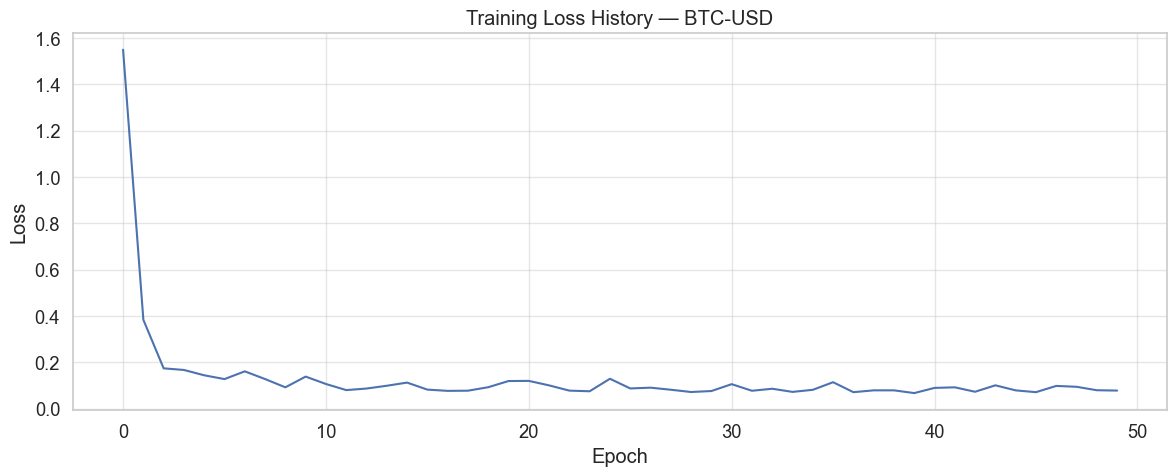


Training completed! Final loss: 0.077806


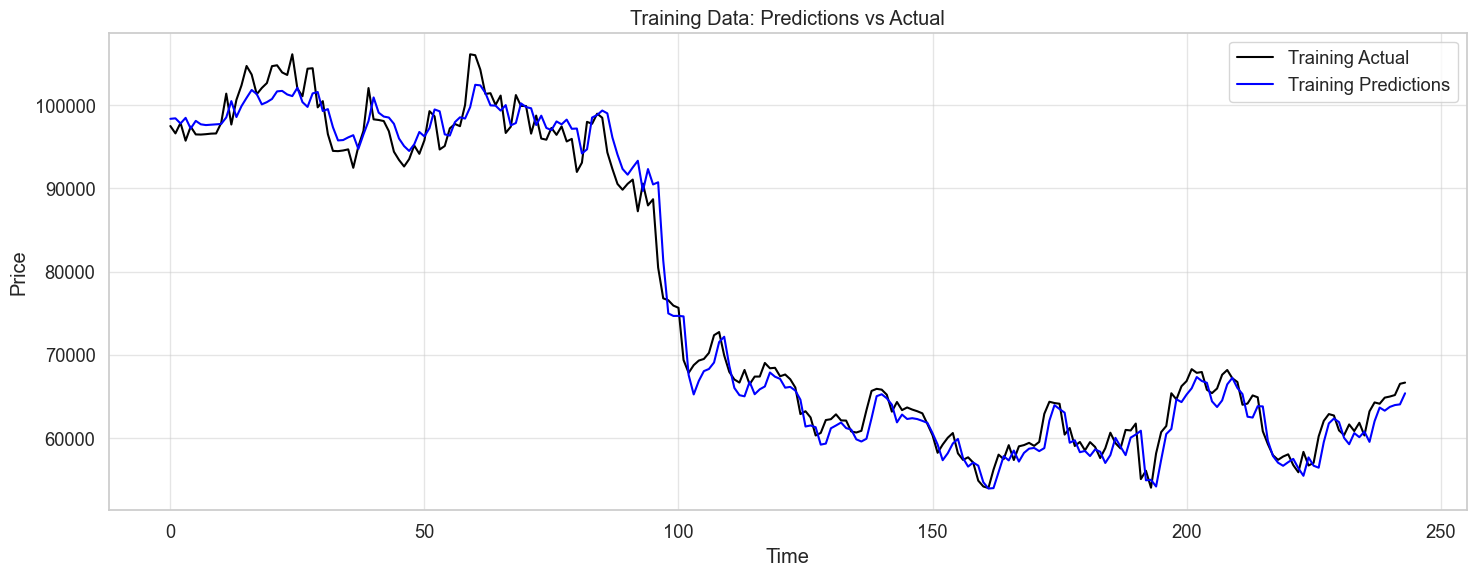

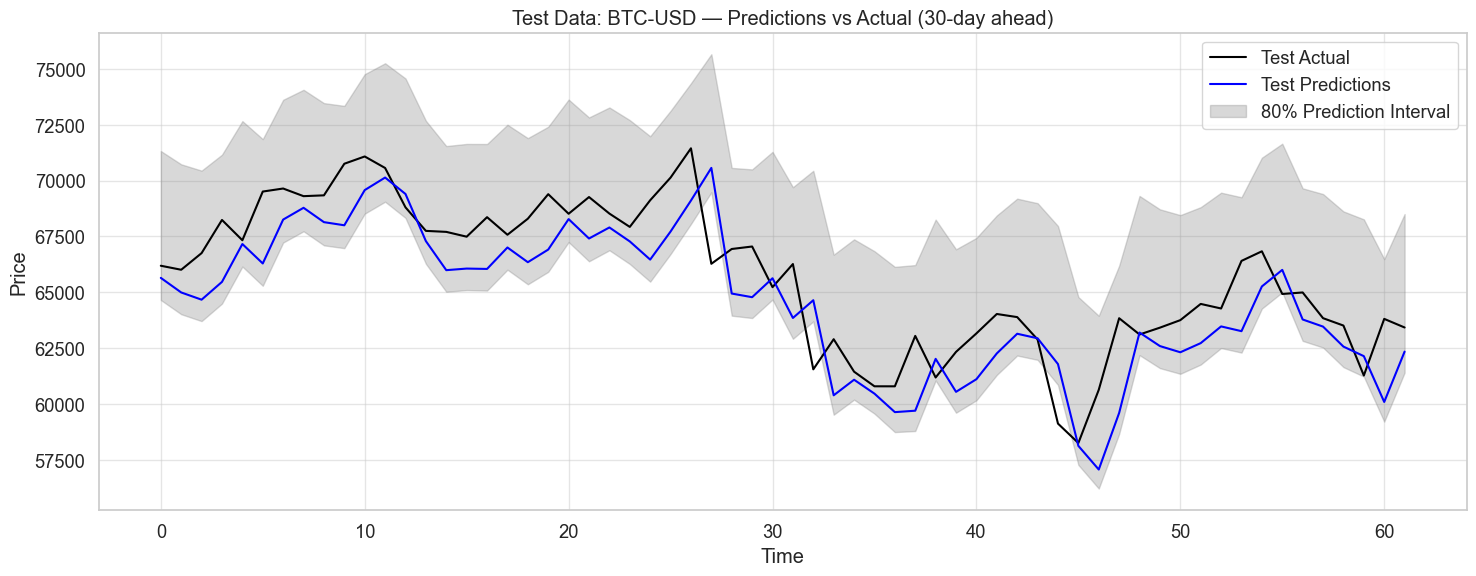


Test Set Metrics:
MAE: 1593.64
RMSE: 1931.79
MAPE: 2.42%
✅ Saved forecast to forecast_outputs/BTC-USD.json
✅ Saved model to models/model_BTC-USD.pt


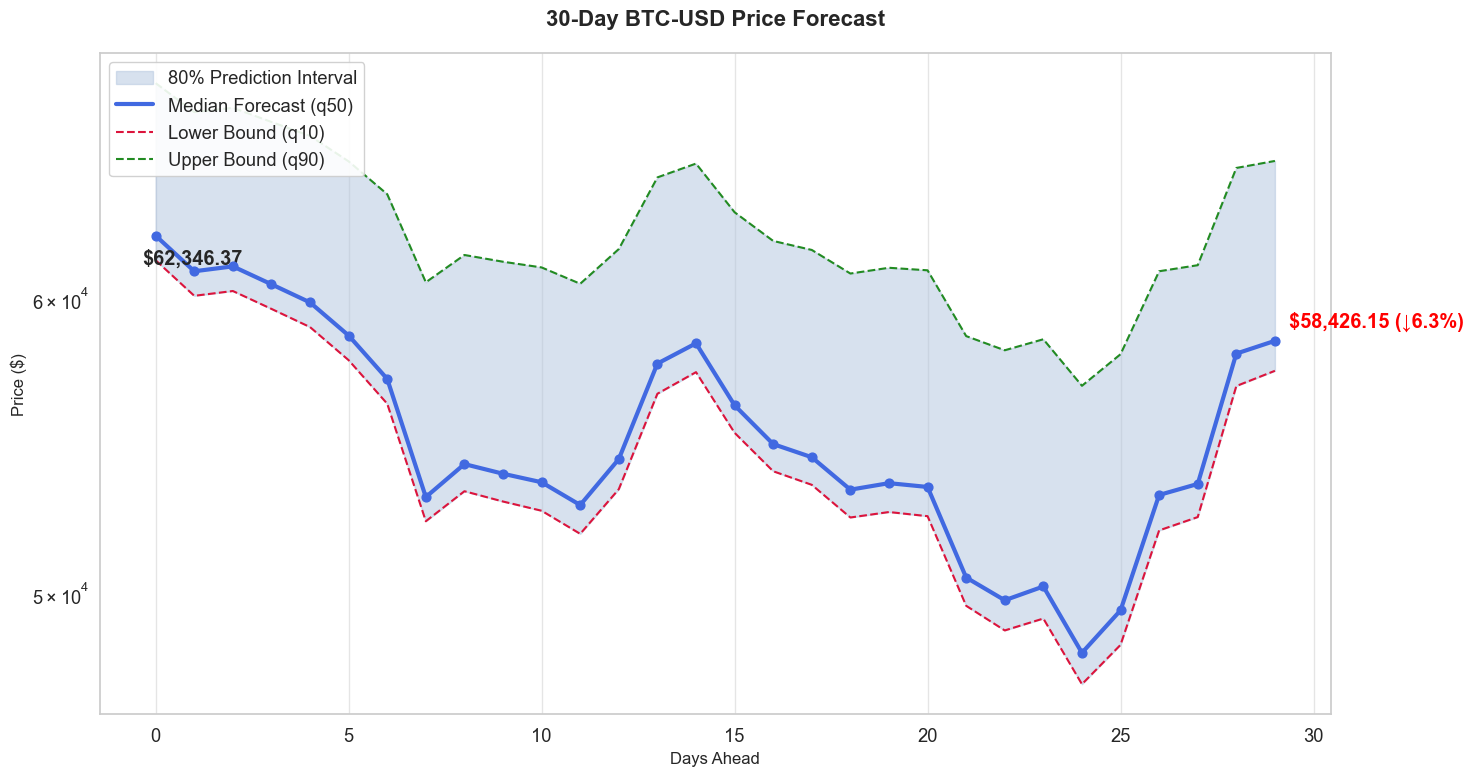

[I 2025-04-15 17:21:00,795] A new study created in memory with name: no-name-b50ad726-b765-45a7-8dc0-815ac9bfd2d9


✅ Completed: BTC-USD

🏁 Running pipeline for ETH-USD
📁 Saved historical data to: C:\Users\Chico\OneDrive\Ambiente de Trabalho\Quant LSTM\yf data\ETH-USD.csv

STARTING HYPERPARAMETER OPTIMIZATION
Number of trials: 20
Parameters being optimized:
  - lookback window (30-90 days)
  - hidden size (64-256 neurons)
  - number of LSTM layers (1-5)
  - dropout rate (0.0-0.5)
  - learning rate (1e-4 to 1e-2)
  - batch size (8, 16, 32, 64)


Trial #0:
  lookback: 80, hidden_size: 192, num_layers: 3
  dropout: 0.4, learning_rate: 0.000984074483084244, batch_size: 32
    Epoch 1/15 - Validation Loss: 1.477956 (best)
    Epoch 2/15 - Validation Loss: 1.863839
    Epoch 3/15 - Validation Loss: 0.728109 (best)
    Epoch 4/15 - Validation Loss: 1.187853
    Epoch 5/15 - Validation Loss: 0.468900 (best)
    Epoch 6/15 - Validation Loss: 0.273121 (best)
    Epoch 7/15 - Validation Loss: 0.112089 (best)
    Epoch 8/15 - Validation Loss: 0.168182
    Epoch 9/15 - Validation Loss: 0.210690
    Epoch 10/15 -

[I 2025-04-15 17:21:08,091] Trial 0 finished with value: 0.11208906397223473 and parameters: {'lookback': 80, 'hidden_size': 192, 'num_layers': 3, 'dropout': 0.4, 'learning_rate': 0.000984074483084244, 'batch_size': 32}. Best is trial 0 with value: 0.11208906397223473.


    Epoch 12/15 - Validation Loss: 0.160313
    Early stopping at epoch 12
  Final validation loss: 0.112089

Trial #1:
  lookback: 90, hidden_size: 160, num_layers: 5
  dropout: 0.4, learning_rate: 0.0011122923804623291, batch_size: 32
    Epoch 1/15 - Validation Loss: 1.627645 (best)
    Epoch 2/15 - Validation Loss: 0.742925 (best)
    Epoch 3/15 - Validation Loss: 0.930343
    Epoch 4/15 - Validation Loss: 0.436914 (best)
    Epoch 5/15 - Validation Loss: 0.260980 (best)
    Epoch 6/15 - Validation Loss: 0.363979
    Epoch 7/15 - Validation Loss: 0.279527
    Epoch 8/15 - Validation Loss: 0.137281 (best)
    Epoch 9/15 - Validation Loss: 0.290206
    Epoch 10/15 - Validation Loss: 0.240744
    Epoch 11/15 - Validation Loss: 0.185036
    Epoch 12/15 - Validation Loss: 0.160575


[I 2025-04-15 17:21:18,530] Trial 1 finished with value: 0.13728058710694313 and parameters: {'lookback': 90, 'hidden_size': 160, 'num_layers': 5, 'dropout': 0.4, 'learning_rate': 0.0011122923804623291, 'batch_size': 32}. Best is trial 0 with value: 0.11208906397223473.


    Epoch 13/15 - Validation Loss: 0.143466
    Early stopping at epoch 13
  Final validation loss: 0.137281

Trial #2:
  lookback: 60, hidden_size: 96, num_layers: 4
  dropout: 0.4, learning_rate: 0.009349348222808276, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.480048 (best)
    Epoch 2/15 - Validation Loss: 0.211320 (best)
    Epoch 3/15 - Validation Loss: 0.335453
    Epoch 4/15 - Validation Loss: 0.197667 (best)
    Epoch 5/15 - Validation Loss: 0.303828
    Epoch 6/15 - Validation Loss: 0.122619 (best)
    Epoch 7/15 - Validation Loss: 0.120037 (best)
    Epoch 8/15 - Validation Loss: 0.150283
    Epoch 9/15 - Validation Loss: 0.153316
    Epoch 10/15 - Validation Loss: 0.122746
    Epoch 11/15 - Validation Loss: 0.143139


[I 2025-04-15 17:21:38,067] Trial 2 finished with value: 0.12003734335303307 and parameters: {'lookback': 60, 'hidden_size': 96, 'num_layers': 4, 'dropout': 0.4, 'learning_rate': 0.009349348222808276, 'batch_size': 8}. Best is trial 0 with value: 0.11208906397223473.


    Epoch 12/15 - Validation Loss: 0.242181
    Early stopping at epoch 12
  Final validation loss: 0.120037

Trial #3:
  lookback: 90, hidden_size: 64, num_layers: 5
  dropout: 0.0, learning_rate: 0.0010921464481878217, batch_size: 32
    Epoch 1/15 - Validation Loss: 1.034950 (best)
    Epoch 2/15 - Validation Loss: 0.634206 (best)
    Epoch 3/15 - Validation Loss: 0.463700 (best)
    Epoch 4/15 - Validation Loss: 0.454491 (best)
    Epoch 5/15 - Validation Loss: 0.175343 (best)
    Epoch 6/15 - Validation Loss: 0.232268
    Epoch 7/15 - Validation Loss: 0.254263
    Epoch 8/15 - Validation Loss: 0.176551
    Epoch 9/15 - Validation Loss: 0.207965


[I 2025-04-15 17:21:44,896] Trial 3 finished with value: 0.17534326761960983 and parameters: {'lookback': 90, 'hidden_size': 64, 'num_layers': 5, 'dropout': 0.0, 'learning_rate': 0.0010921464481878217, 'batch_size': 32}. Best is trial 0 with value: 0.11208906397223473.


    Epoch 10/15 - Validation Loss: 0.240027
    Early stopping at epoch 10
  Final validation loss: 0.175343

Trial #4:
  lookback: 40, hidden_size: 192, num_layers: 2
  dropout: 0.1, learning_rate: 0.0031367702179284293, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.376675 (best)
    Epoch 2/15 - Validation Loss: 0.216472 (best)
    Epoch 3/15 - Validation Loss: 0.113639 (best)
    Epoch 4/15 - Validation Loss: 0.218045
    Epoch 5/15 - Validation Loss: 0.122460
    Epoch 6/15 - Validation Loss: 0.395980
    Epoch 7/15 - Validation Loss: 0.221141
    Epoch 8/15 - Validation Loss: 0.103276 (best)
    Epoch 9/15 - Validation Loss: 0.129711
    Epoch 10/15 - Validation Loss: 0.138115
    Epoch 11/15 - Validation Loss: 0.092630 (best)
    Epoch 12/15 - Validation Loss: 0.138594
    Epoch 13/15 - Validation Loss: 0.102762
    Epoch 14/15 - Validation Loss: 0.132497


[I 2025-04-15 17:21:57,532] Trial 4 finished with value: 0.09262953946987788 and parameters: {'lookback': 40, 'hidden_size': 192, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0031367702179284293, 'batch_size': 8}. Best is trial 4 with value: 0.09262953946987788.


    Epoch 15/15 - Validation Loss: 0.131305
  Final validation loss: 0.092630

Trial #5:
  lookback: 70, hidden_size: 160, num_layers: 5
  dropout: 0.0, learning_rate: 0.00014963043167008001, batch_size: 64
    Epoch 1/15 - Validation Loss: 0.536016 (best)
    Epoch 2/15 - Validation Loss: 0.338536 (best)
    Epoch 3/15 - Validation Loss: 0.243164 (best)
    Epoch 4/15 - Validation Loss: 0.186539 (best)
    Epoch 5/15 - Validation Loss: 0.288893
    Epoch 6/15 - Validation Loss: 0.217418
    Epoch 7/15 - Validation Loss: 0.245699


[I 2025-04-15 17:22:01,766] Trial 5 pruned. 


    Epoch 8/15 - Validation Loss: 0.201881
    Trial pruned at epoch 8

Trial #6:
  lookback: 60, hidden_size: 96, num_layers: 4
  dropout: 0.1, learning_rate: 0.0011334447401462448, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.303588 (best)
    Epoch 2/15 - Validation Loss: 0.195323 (best)
    Epoch 3/15 - Validation Loss: 0.225944
    Epoch 4/15 - Validation Loss: 0.371577
    Epoch 5/15 - Validation Loss: 0.180891 (best)
    Epoch 6/15 - Validation Loss: 0.169448 (best)
    Epoch 7/15 - Validation Loss: 0.127458 (best)
    Epoch 8/15 - Validation Loss: 0.305029
    Epoch 9/15 - Validation Loss: 0.146548
    Epoch 10/15 - Validation Loss: 0.122306 (best)
    Epoch 11/15 - Validation Loss: 0.180387
    Epoch 12/15 - Validation Loss: 0.228037
    Epoch 13/15 - Validation Loss: 0.178338
    Epoch 14/15 - Validation Loss: 0.173791


[I 2025-04-15 17:22:19,010] Trial 6 finished with value: 0.12230636055270831 and parameters: {'lookback': 60, 'hidden_size': 96, 'num_layers': 4, 'dropout': 0.1, 'learning_rate': 0.0011334447401462448, 'batch_size': 8}. Best is trial 4 with value: 0.09262953946987788.
c:\Users\Chico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
[I 2025-04-15 17:22:19,176] Trial 7 pruned. 


    Epoch 15/15 - Validation Loss: 0.136319
    Early stopping at epoch 15
  Final validation loss: 0.122306

Trial #7:
  lookback: 50, hidden_size: 128, num_layers: 1
  dropout: 0.1, learning_rate: 0.00021496382928194057, batch_size: 64
    Epoch 1/15 - Validation Loss: 0.567794 (best)
    Epoch 2/15 - Validation Loss: 0.480586 (best)
    Trial pruned at epoch 2

Trial #8:
  lookback: 90, hidden_size: 224, num_layers: 4
  dropout: 0.30000000000000004, learning_rate: 0.0013054889818952665, batch_size: 16


[I 2025-04-15 17:22:20,536] Trial 8 pruned. 


    Epoch 1/15 - Validation Loss: 1.106726 (best)
    Trial pruned at epoch 1

Trial #9:
  lookback: 60, hidden_size: 160, num_layers: 3
  dropout: 0.30000000000000004, learning_rate: 0.0015768476969886512, batch_size: 16


[I 2025-04-15 17:22:21,177] Trial 9 pruned. 


    Epoch 1/15 - Validation Loss: 1.443484 (best)
    Trial pruned at epoch 1

Trial #10:
  lookback: 30, hidden_size: 256, num_layers: 1
  dropout: 0.2, learning_rate: 0.0069575630467306245, batch_size: 8


c:\Users\Chico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


    Epoch 1/15 - Validation Loss: 0.270677 (best)
    Epoch 2/15 - Validation Loss: 0.205784 (best)
    Epoch 3/15 - Validation Loss: 0.192102 (best)
    Epoch 4/15 - Validation Loss: 0.277804
    Epoch 5/15 - Validation Loss: 0.168931 (best)
    Epoch 6/15 - Validation Loss: 0.124403 (best)
    Epoch 7/15 - Validation Loss: 0.161938
    Epoch 8/15 - Validation Loss: 0.208665
    Epoch 9/15 - Validation Loss: 0.206318
    Epoch 10/15 - Validation Loss: 0.218717


[I 2025-04-15 17:22:24,579] Trial 10 finished with value: 0.12440325816472371 and parameters: {'lookback': 30, 'hidden_size': 256, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.0069575630467306245, 'batch_size': 8}. Best is trial 4 with value: 0.09262953946987788.


    Epoch 11/15 - Validation Loss: 0.161139
    Early stopping at epoch 11
  Final validation loss: 0.124403

Trial #11:
  lookback: 30, hidden_size: 224, num_layers: 2
  dropout: 0.5, learning_rate: 0.003396872971578148, batch_size: 32


[I 2025-04-15 17:22:24,891] Trial 11 pruned. 


    Epoch 1/15 - Validation Loss: 0.950399 (best)
    Trial pruned at epoch 1

Trial #12:
  lookback: 40, hidden_size: 224, num_layers: 2
  dropout: 0.2, learning_rate: 0.0004124047031416944, batch_size: 8


[I 2025-04-15 17:22:25,600] Trial 12 pruned. 


    Epoch 1/15 - Validation Loss: 0.734848 (best)
    Trial pruned at epoch 1

Trial #13:
  lookback: 70, hidden_size: 192, num_layers: 2
  dropout: 0.5, learning_rate: 0.003110852694054725, batch_size: 32


[I 2025-04-15 17:22:26,071] Trial 13 pruned. 


    Epoch 1/15 - Validation Loss: 1.721234 (best)
    Trial pruned at epoch 1

Trial #14:
  lookback: 80, hidden_size: 192, num_layers: 3
  dropout: 0.4, learning_rate: 0.0004431400403926947, batch_size: 32


[I 2025-04-15 17:22:26,727] Trial 14 pruned. 


    Epoch 1/15 - Validation Loss: 0.912690 (best)
    Trial pruned at epoch 1

Trial #15:
  lookback: 40, hidden_size: 192, num_layers: 3
  dropout: 0.1, learning_rate: 0.002536896779140532, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.400593 (best)
    Epoch 2/15 - Validation Loss: 0.196998 (best)
    Epoch 3/15 - Validation Loss: 0.147174 (best)
    Epoch 4/15 - Validation Loss: 0.269370
    Epoch 5/15 - Validation Loss: 0.202275
    Epoch 6/15 - Validation Loss: 0.163355
    Epoch 7/15 - Validation Loss: 0.188444


[I 2025-04-15 17:22:35,056] Trial 15 finished with value: 0.1471735549469789 and parameters: {'lookback': 40, 'hidden_size': 192, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.002536896779140532, 'batch_size': 8}. Best is trial 4 with value: 0.09262953946987788.


    Epoch 8/15 - Validation Loss: 0.182515
    Early stopping at epoch 8
  Final validation loss: 0.147174

Trial #16:
  lookback: 50, hidden_size: 256, num_layers: 2
  dropout: 0.2, learning_rate: 0.0005034776048029638, batch_size: 64


[I 2025-04-15 17:22:35,417] Trial 16 pruned. 


    Epoch 1/15 - Validation Loss: 1.155603 (best)
    Trial pruned at epoch 1

Trial #17:
  lookback: 80, hidden_size: 128, num_layers: 1
  dropout: 0.30000000000000004, learning_rate: 0.004468450754586433, batch_size: 16


c:\Users\Chico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(
[I 2025-04-15 17:22:35,819] Trial 17 pruned. 


    Epoch 1/15 - Validation Loss: 1.227653 (best)
    Trial pruned at epoch 1

Trial #18:
  lookback: 40, hidden_size: 192, num_layers: 2
  dropout: 0.1, learning_rate: 0.002020654136614212, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.404975 (best)


[I 2025-04-15 17:22:37,268] Trial 18 pruned. 


    Epoch 2/15 - Validation Loss: 0.255364 (best)
    Trial pruned at epoch 2

Trial #19:
  lookback: 70, hidden_size: 128, num_layers: 3
  dropout: 0.4, learning_rate: 0.0006266798584768297, batch_size: 32


[I 2025-04-15 17:22:37,735] Trial 19 pruned. 


    Epoch 1/15 - Validation Loss: 1.193077 (best)
    Trial pruned at epoch 1

OPTIMIZATION RESULTS
Best trial: #4
Best validation loss: 0.092630

Best hyperparameters:
  - lookback: 40
  - hidden_size: 192
  - num_layers: 2
  - dropout: 0.1
  - learning_rate: 0.0031367702179284293
  - batch_size: 8
Unable to display Optuna visualization: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.


[ETH-USD] Epoch 1/50: 100%|██████████| 30/30 [00:00<00:00, 30.72it/s, loss=0.449]


[Epoch 1/50] Training Loss: 0.979915
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 2/50: 100%|██████████| 30/30 [00:01<00:00, 29.75it/s, loss=0.203]


[Epoch 2/50] Training Loss: 0.290194
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 3/50: 100%|██████████| 30/30 [00:00<00:00, 31.92it/s, loss=0.201] 


[Epoch 3/50] Training Loss: 0.152845
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 4/50: 100%|██████████| 30/30 [00:01<00:00, 29.33it/s, loss=0.203] 


[Epoch 4/50] Training Loss: 0.181943
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 5/50: 100%|██████████| 30/30 [00:00<00:00, 31.41it/s, loss=0.168]


[Epoch 5/50] Training Loss: 0.150793
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 6/50: 100%|██████████| 30/30 [00:01<00:00, 29.66it/s, loss=0.137]


[Epoch 6/50] Training Loss: 0.163464
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 7/50: 100%|██████████| 30/30 [00:00<00:00, 30.61it/s, loss=0.212] 


[Epoch 7/50] Training Loss: 0.166260
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 8/50: 100%|██████████| 30/30 [00:01<00:00, 29.22it/s, loss=0.215] 


[Epoch 8/50] Training Loss: 0.167356
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 9/50: 100%|██████████| 30/30 [00:00<00:00, 31.26it/s, loss=0.136] 


[Epoch 9/50] Training Loss: 0.151177
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 10/50: 100%|██████████| 30/30 [00:01<00:00, 29.94it/s, loss=0.0909]


[Epoch 10/50] Training Loss: 0.132659
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 11/50: 100%|██████████| 30/30 [00:01<00:00, 28.98it/s, loss=0.115] 


[Epoch 11/50] Training Loss: 0.130045
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 12/50: 100%|██████████| 30/30 [00:00<00:00, 30.99it/s, loss=0.0903]


[Epoch 12/50] Training Loss: 0.124694
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 13/50: 100%|██████████| 30/30 [00:00<00:00, 31.80it/s, loss=0.206] 


[Epoch 13/50] Training Loss: 0.131229
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 14/50: 100%|██████████| 30/30 [00:00<00:00, 30.25it/s, loss=0.0841]


[Epoch 14/50] Training Loss: 0.137963
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 15/50: 100%|██████████| 30/30 [00:00<00:00, 31.12it/s, loss=0.121] 


[Epoch 15/50] Training Loss: 0.113623
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 16/50: 100%|██████████| 30/30 [00:01<00:00, 29.65it/s, loss=0.131] 


[Epoch 16/50] Training Loss: 0.147858
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 17/50: 100%|██████████| 30/30 [00:00<00:00, 30.19it/s, loss=0.212] 


[Epoch 17/50] Training Loss: 0.129751
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 18/50: 100%|██████████| 30/30 [00:00<00:00, 31.67it/s, loss=0.228] 


[Epoch 18/50] Training Loss: 0.138072
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 19/50: 100%|██████████| 30/30 [00:00<00:00, 30.88it/s, loss=0.0709]


[Epoch 19/50] Training Loss: 0.133729
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 20/50: 100%|██████████| 30/30 [00:01<00:00, 29.64it/s, loss=0.125] 


[Epoch 20/50] Training Loss: 0.119175
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 21/50: 100%|██████████| 30/30 [00:00<00:00, 30.12it/s, loss=0.12]  


[Epoch 21/50] Training Loss: 0.119552
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 22/50: 100%|██████████| 30/30 [00:00<00:00, 31.09it/s, loss=0.0937]


[Epoch 22/50] Training Loss: 0.125993
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 23/50: 100%|██████████| 30/30 [00:01<00:00, 29.02it/s, loss=0.197] 


[Epoch 23/50] Training Loss: 0.124906
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 24/50: 100%|██████████| 30/30 [00:00<00:00, 30.90it/s, loss=0.119] 


[Epoch 24/50] Training Loss: 0.122520
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 25/50: 100%|██████████| 30/30 [00:00<00:00, 30.04it/s, loss=0.167] 


[Epoch 25/50] Training Loss: 0.114703
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 26/50: 100%|██████████| 30/30 [00:00<00:00, 31.94it/s, loss=0.112] 


[Epoch 26/50] Training Loss: 0.119453
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 27/50: 100%|██████████| 30/30 [00:00<00:00, 30.20it/s, loss=0.124] 


[Epoch 27/50] Training Loss: 0.127179
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 28/50: 100%|██████████| 30/30 [00:00<00:00, 30.33it/s, loss=0.193] 


[Epoch 28/50] Training Loss: 0.143986
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 29/50: 100%|██████████| 30/30 [00:01<00:00, 28.04it/s, loss=0.0849]


[Epoch 29/50] Training Loss: 0.110837
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 30/50: 100%|██████████| 30/30 [00:00<00:00, 31.10it/s, loss=0.0926]


[Epoch 30/50] Training Loss: 0.114670
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 31/50: 100%|██████████| 30/30 [00:01<00:00, 28.91it/s, loss=0.118] 


[Epoch 31/50] Training Loss: 0.122772
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 32/50: 100%|██████████| 30/30 [00:01<00:00, 24.46it/s, loss=0.0959]


[Epoch 32/50] Training Loss: 0.110531
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 33/50: 100%|██████████| 30/30 [00:01<00:00, 26.01it/s, loss=0.0935]


[Epoch 33/50] Training Loss: 0.116493
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 34/50: 100%|██████████| 30/30 [00:00<00:00, 30.50it/s, loss=0.102] 


[Epoch 34/50] Training Loss: 0.111633
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 35/50: 100%|██████████| 30/30 [00:00<00:00, 32.15it/s, loss=0.252] 


[Epoch 35/50] Training Loss: 0.110880
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 36/50: 100%|██████████| 30/30 [00:00<00:00, 31.05it/s, loss=0.0994]


[Epoch 36/50] Training Loss: 0.119483
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 37/50: 100%|██████████| 30/30 [00:01<00:00, 29.93it/s, loss=0.243] 


[Epoch 37/50] Training Loss: 0.107514
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 38/50: 100%|██████████| 30/30 [00:01<00:00, 29.81it/s, loss=0.0799]


[Epoch 38/50] Training Loss: 0.111552
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 39/50: 100%|██████████| 30/30 [00:01<00:00, 29.27it/s, loss=0.189] 


[Epoch 39/50] Training Loss: 0.133297
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 40/50: 100%|██████████| 30/30 [00:00<00:00, 30.51it/s, loss=0.173] 


[Epoch 40/50] Training Loss: 0.136224
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 41/50: 100%|██████████| 30/30 [00:00<00:00, 30.10it/s, loss=0.0762]


[Epoch 41/50] Training Loss: 0.139290
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 42/50: 100%|██████████| 30/30 [00:00<00:00, 31.06it/s, loss=0.196] 


[Epoch 42/50] Training Loss: 0.112992
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 43/50: 100%|██████████| 30/30 [00:01<00:00, 28.87it/s, loss=0.0705]


[Epoch 43/50] Training Loss: 0.115896
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 44/50: 100%|██████████| 30/30 [00:00<00:00, 30.45it/s, loss=0.115] 


[Epoch 44/50] Training Loss: 0.105205
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 45/50: 100%|██████████| 30/30 [00:00<00:00, 30.18it/s, loss=0.0573]


[Epoch 45/50] Training Loss: 0.117073
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 46/50: 100%|██████████| 30/30 [00:00<00:00, 30.67it/s, loss=0.0577]


[Epoch 46/50] Training Loss: 0.110398
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 47/50: 100%|██████████| 30/30 [00:01<00:00, 28.88it/s, loss=0.125] 


[Epoch 47/50] Training Loss: 0.119820
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 48/50: 100%|██████████| 30/30 [00:00<00:00, 30.16it/s, loss=0.0994]


[Epoch 48/50] Training Loss: 0.106023
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 49/50: 100%|██████████| 30/30 [00:00<00:00, 31.23it/s, loss=0.156] 


[Epoch 49/50] Training Loss: 0.124864
Current learning rate: 0.0031367702179284293


[ETH-USD] Epoch 50/50: 100%|██████████| 30/30 [00:00<00:00, 31.54it/s, loss=0.107] 


[Epoch 50/50] Training Loss: 0.113947
Current learning rate: 0.0031367702179284293


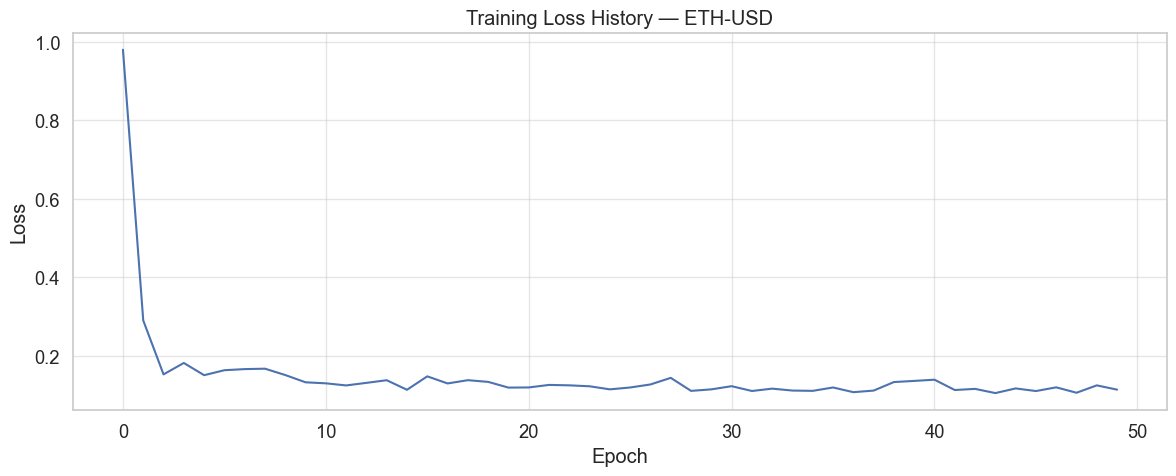


Training completed! Final loss: 0.113947


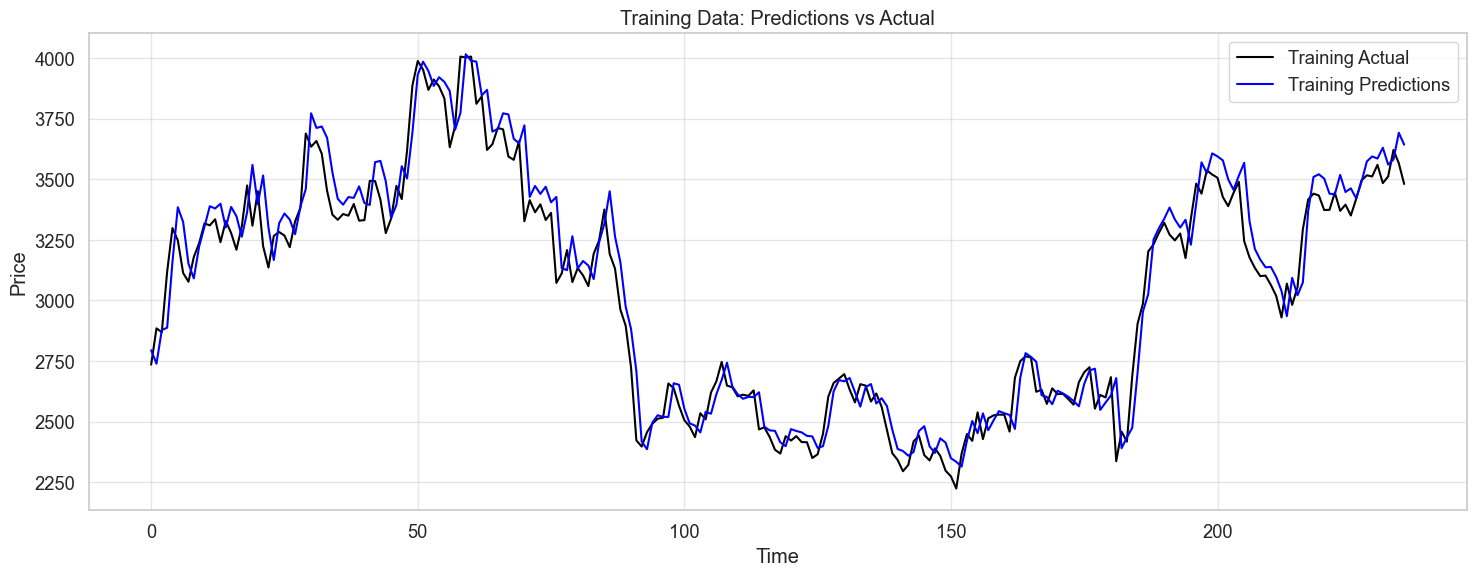

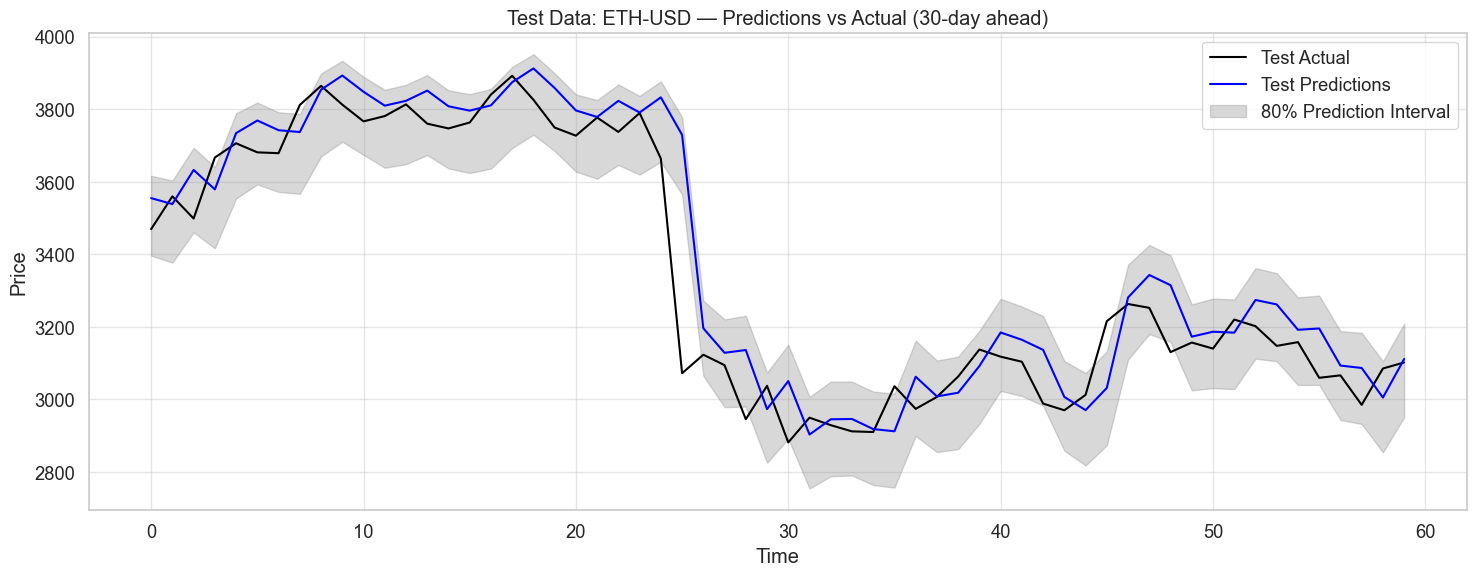


Test Set Metrics:
MAE: 77.52
RMSE: 118.85
MAPE: 2.39%
✅ Saved forecast to forecast_outputs/ETH-USD.json
✅ Saved model to models/model_ETH-USD.pt


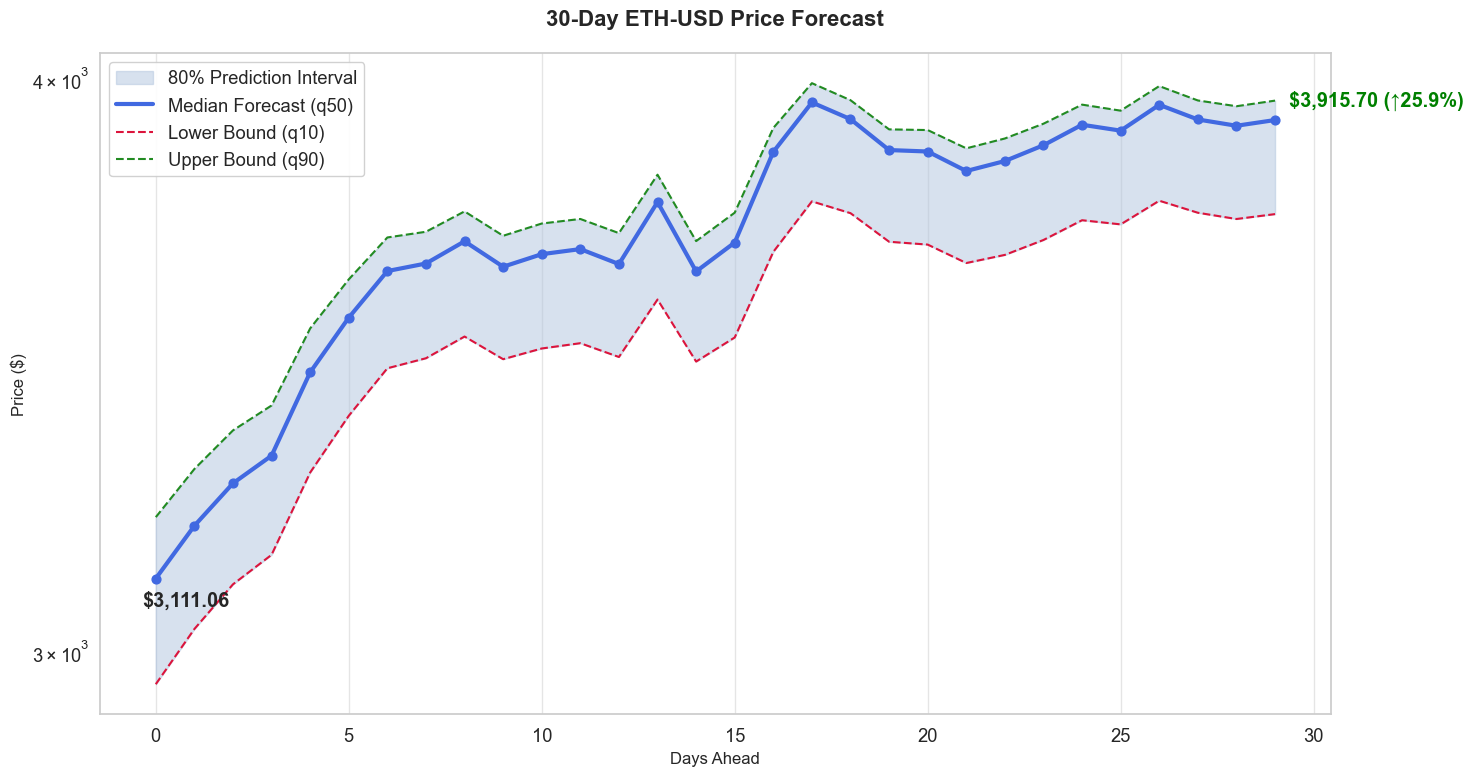

[I 2025-04-15 17:23:29,251] A new study created in memory with name: no-name-9c363748-fa24-4f7b-8075-3aae011300f4


✅ Completed: ETH-USD

🏁 Running pipeline for EURUSD=X
📁 Saved historical data to: C:\Users\Chico\OneDrive\Ambiente de Trabalho\Quant LSTM\yf data\EURUSD=X.csv

STARTING HYPERPARAMETER OPTIMIZATION
Number of trials: 20
Parameters being optimized:
  - lookback window (30-90 days)
  - hidden size (64-256 neurons)
  - number of LSTM layers (1-5)
  - dropout rate (0.0-0.5)
  - learning rate (1e-4 to 1e-2)
  - batch size (8, 16, 32, 64)


Trial #0:
  lookback: 40, hidden_size: 96, num_layers: 3
  dropout: 0.0, learning_rate: 0.005007470907663878, batch_size: 64
    Epoch 1/15 - Validation Loss: 2.315473 (best)
    Epoch 2/15 - Validation Loss: 1.338843 (best)
    Epoch 3/15 - Validation Loss: 0.700680 (best)
    Epoch 4/15 - Validation Loss: 0.459058 (best)
    Epoch 5/15 - Validation Loss: 0.422862 (best)
    Epoch 6/15 - Validation Loss: 0.352779 (best)
    Epoch 7/15 - Validation Loss: 0.622956
    Epoch 8/15 - Validation Loss: 0.478078
    Epoch 9/15 - Validation Loss: 0.518270


[I 2025-04-15 17:23:30,593] Trial 0 finished with value: 0.35277870297431946 and parameters: {'lookback': 40, 'hidden_size': 96, 'num_layers': 3, 'dropout': 0.0, 'learning_rate': 0.005007470907663878, 'batch_size': 64}. Best is trial 0 with value: 0.35277870297431946.


    Epoch 10/15 - Validation Loss: 0.526743
    Epoch 11/15 - Validation Loss: 0.460419
    Early stopping at epoch 11
  Final validation loss: 0.352779

Trial #1:
  lookback: 50, hidden_size: 256, num_layers: 2
  dropout: 0.5, learning_rate: 0.0006392547190082124, batch_size: 32
    Epoch 1/15 - Validation Loss: 1.444808 (best)
    Epoch 2/15 - Validation Loss: 1.492195
    Epoch 3/15 - Validation Loss: 0.948881 (best)
    Epoch 4/15 - Validation Loss: 1.437259
    Epoch 5/15 - Validation Loss: 0.539479 (best)
    Epoch 6/15 - Validation Loss: 0.600211
    Epoch 7/15 - Validation Loss: 0.725470
    Epoch 8/15 - Validation Loss: 0.675180
    Epoch 9/15 - Validation Loss: 0.549147
    Epoch 10/15 - Validation Loss: 0.468713 (best)
    Epoch 11/15 - Validation Loss: 0.572025
    Epoch 12/15 - Validation Loss: 0.484525
    Epoch 13/15 - Validation Loss: 0.559823
    Epoch 14/15 - Validation Loss: 0.517868
    Epoch 15/15 - Validation Loss: 0.523482
    Early stopping at epoch 15
  Final v

[I 2025-04-15 17:23:34,464] Trial 1 finished with value: 0.46871259808540344 and parameters: {'lookback': 50, 'hidden_size': 256, 'num_layers': 2, 'dropout': 0.5, 'learning_rate': 0.0006392547190082124, 'batch_size': 32}. Best is trial 0 with value: 0.35277870297431946.



Trial #2:
  lookback: 40, hidden_size: 96, num_layers: 1
  dropout: 0.0, learning_rate: 0.007718607667920038, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.243721 (best)
    Epoch 2/15 - Validation Loss: 0.123031 (best)
    Epoch 3/15 - Validation Loss: 0.124075
    Epoch 4/15 - Validation Loss: 0.187756
    Epoch 5/15 - Validation Loss: 0.162412
    Epoch 6/15 - Validation Loss: 0.239919


[I 2025-04-15 17:23:35,822] Trial 2 finished with value: 0.12303061783313751 and parameters: {'lookback': 40, 'hidden_size': 96, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.007718607667920038, 'batch_size': 8}. Best is trial 2 with value: 0.12303061783313751.


    Epoch 7/15 - Validation Loss: 0.132237
    Early stopping at epoch 7
  Final validation loss: 0.123031

Trial #3:
  lookback: 80, hidden_size: 192, num_layers: 3
  dropout: 0.1, learning_rate: 0.0011587427573320672, batch_size: 16
    Epoch 1/15 - Validation Loss: 1.974691 (best)
    Epoch 2/15 - Validation Loss: 0.774895 (best)
    Epoch 3/15 - Validation Loss: 0.484735 (best)
    Epoch 4/15 - Validation Loss: 0.406852 (best)
    Epoch 5/15 - Validation Loss: 0.454160
    Epoch 6/15 - Validation Loss: 0.282579 (best)
    Epoch 7/15 - Validation Loss: 0.194957 (best)
    Epoch 8/15 - Validation Loss: 0.358015
    Epoch 9/15 - Validation Loss: 0.194308 (best)
    Epoch 10/15 - Validation Loss: 0.213635
    Epoch 11/15 - Validation Loss: 0.359804
    Epoch 12/15 - Validation Loss: 0.208052
    Epoch 13/15 - Validation Loss: 0.221385


[I 2025-04-15 17:23:42,128] Trial 3 finished with value: 0.19430750608444214 and parameters: {'lookback': 80, 'hidden_size': 192, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0011587427573320672, 'batch_size': 16}. Best is trial 2 with value: 0.12303061783313751.


    Epoch 14/15 - Validation Loss: 0.219173
    Early stopping at epoch 14
  Final validation loss: 0.194308

Trial #4:
  lookback: 70, hidden_size: 256, num_layers: 5
  dropout: 0.4, learning_rate: 0.00015314846890655012, batch_size: 64
    Epoch 1/15 - Validation Loss: 0.555500 (best)
    Epoch 2/15 - Validation Loss: 0.524888 (best)
    Epoch 3/15 - Validation Loss: 0.515630 (best)
    Epoch 4/15 - Validation Loss: 0.360407 (best)
    Epoch 5/15 - Validation Loss: 0.315380 (best)
    Epoch 6/15 - Validation Loss: 0.339245
    Epoch 7/15 - Validation Loss: 0.442118
    Epoch 8/15 - Validation Loss: 0.314267 (best)
    Epoch 9/15 - Validation Loss: 0.282151 (best)
    Epoch 10/15 - Validation Loss: 0.321782
    Epoch 11/15 - Validation Loss: 0.333443
    Epoch 12/15 - Validation Loss: 0.238022 (best)
    Epoch 13/15 - Validation Loss: 0.220345 (best)
    Epoch 14/15 - Validation Loss: 0.333495


[I 2025-04-15 17:23:52,120] Trial 4 finished with value: 0.22034530341625214 and parameters: {'lookback': 70, 'hidden_size': 256, 'num_layers': 5, 'dropout': 0.4, 'learning_rate': 0.00015314846890655012, 'batch_size': 64}. Best is trial 2 with value: 0.12303061783313751.


    Epoch 15/15 - Validation Loss: 0.323885
  Final validation loss: 0.220345

Trial #5:
  lookback: 50, hidden_size: 64, num_layers: 3
  dropout: 0.30000000000000004, learning_rate: 0.00030604528290643424, batch_size: 64
    Epoch 1/15 - Validation Loss: 0.478592 (best)
    Epoch 2/15 - Validation Loss: 0.580029
    Epoch 3/15 - Validation Loss: 0.591328


[I 2025-04-15 17:23:52,673] Trial 5 pruned. 


    Epoch 4/15 - Validation Loss: 0.568111
    Trial pruned at epoch 4

Trial #6:
  lookback: 80, hidden_size: 256, num_layers: 3
  dropout: 0.2, learning_rate: 0.006431904119729617, batch_size: 32


[I 2025-04-15 17:23:53,280] Trial 6 pruned. 


    Epoch 1/15 - Validation Loss: 7.224482 (best)
    Trial pruned at epoch 1

Trial #7:
  lookback: 70, hidden_size: 64, num_layers: 5
  dropout: 0.2, learning_rate: 0.0006325075828941925, batch_size: 16
    Epoch 1/15 - Validation Loss: 0.804027 (best)
    Epoch 2/15 - Validation Loss: 0.308041 (best)
    Epoch 3/15 - Validation Loss: 0.270029 (best)
    Epoch 4/15 - Validation Loss: 0.272159
    Epoch 5/15 - Validation Loss: 0.349887
    Epoch 6/15 - Validation Loss: 0.269997 (best)
    Epoch 7/15 - Validation Loss: 0.231900 (best)
    Epoch 8/15 - Validation Loss: 0.262371
    Epoch 9/15 - Validation Loss: 0.253342
    Epoch 10/15 - Validation Loss: 0.271441
    Epoch 11/15 - Validation Loss: 0.207951 (best)
    Epoch 12/15 - Validation Loss: 0.256916
    Epoch 13/15 - Validation Loss: 0.309920
    Epoch 14/15 - Validation Loss: 0.267608


[I 2025-04-15 17:24:02,040] Trial 7 finished with value: 0.20230503380298615 and parameters: {'lookback': 70, 'hidden_size': 64, 'num_layers': 5, 'dropout': 0.2, 'learning_rate': 0.0006325075828941925, 'batch_size': 16}. Best is trial 2 with value: 0.12303061783313751.


    Epoch 15/15 - Validation Loss: 0.202305 (best)
  Final validation loss: 0.202305

Trial #8:
  lookback: 60, hidden_size: 160, num_layers: 3
  dropout: 0.4, learning_rate: 0.0003880139128172835, batch_size: 16


[I 2025-04-15 17:24:02,607] Trial 8 pruned. 


    Epoch 1/15 - Validation Loss: 1.156964 (best)
    Trial pruned at epoch 1

Trial #9:
  lookback: 50, hidden_size: 192, num_layers: 4
  dropout: 0.2, learning_rate: 0.002624420020189604, batch_size: 64


[I 2025-04-15 17:24:03,008] Trial 9 pruned. 


    Epoch 1/15 - Validation Loss: 2.431678 (best)
    Trial pruned at epoch 1

Trial #10:
  lookback: 30, hidden_size: 128, num_layers: 1
  dropout: 0.0, learning_rate: 0.009935720823024878, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.436498 (best)
    Epoch 2/15 - Validation Loss: 0.315971 (best)
    Epoch 3/15 - Validation Loss: 0.378625
    Epoch 4/15 - Validation Loss: 0.106132 (best)
    Epoch 5/15 - Validation Loss: 0.072152 (best)
    Epoch 6/15 - Validation Loss: 0.112552
    Epoch 7/15 - Validation Loss: 0.129666
    Epoch 8/15 - Validation Loss: 0.207494
    Epoch 9/15 - Validation Loss: 0.122813


[I 2025-04-15 17:24:05,519] Trial 10 finished with value: 0.07215194497257471 and parameters: {'lookback': 30, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.009935720823024878, 'batch_size': 8}. Best is trial 10 with value: 0.07215194497257471.


    Epoch 10/15 - Validation Loss: 0.147903
    Early stopping at epoch 10
  Final validation loss: 0.072152

Trial #11:
  lookback: 30, hidden_size: 128, num_layers: 1
  dropout: 0.0, learning_rate: 0.007481946548964136, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.185594 (best)
    Epoch 2/15 - Validation Loss: 0.238217
    Epoch 3/15 - Validation Loss: 0.317333
    Epoch 4/15 - Validation Loss: 0.095139 (best)
    Epoch 5/15 - Validation Loss: 0.230953
    Epoch 6/15 - Validation Loss: 0.059305 (best)
    Epoch 7/15 - Validation Loss: 0.115791
    Epoch 8/15 - Validation Loss: 0.086112
    Epoch 9/15 - Validation Loss: 0.092188
    Epoch 10/15 - Validation Loss: 0.084778


[I 2025-04-15 17:24:08,244] Trial 11 finished with value: 0.0593048008158803 and parameters: {'lookback': 30, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.007481946548964136, 'batch_size': 8}. Best is trial 11 with value: 0.0593048008158803.


    Epoch 11/15 - Validation Loss: 0.129682
    Early stopping at epoch 11
  Final validation loss: 0.059305

Trial #12:
  lookback: 30, hidden_size: 128, num_layers: 1
  dropout: 0.0, learning_rate: 0.00252714217855037, batch_size: 8


[I 2025-04-15 17:24:08,532] Trial 12 pruned. 


    Epoch 1/15 - Validation Loss: 0.705477 (best)
    Trial pruned at epoch 1

Trial #13:
  lookback: 30, hidden_size: 128, num_layers: 1
  dropout: 0.1, learning_rate: 0.003341119639882637, batch_size: 8


c:\Users\Chico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
[I 2025-04-15 17:24:08,875] Trial 13 pruned. 


    Epoch 1/15 - Validation Loss: 1.130692 (best)
    Trial pruned at epoch 1

Trial #14:
  lookback: 30, hidden_size: 160, num_layers: 2
  dropout: 0.1, learning_rate: 0.009726434800015296, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.264024 (best)
    Epoch 2/15 - Validation Loss: 0.142113 (best)
    Epoch 3/15 - Validation Loss: 0.246503
    Epoch 4/15 - Validation Loss: 0.351580
    Epoch 5/15 - Validation Loss: 0.180001
    Epoch 6/15 - Validation Loss: 0.199205
    Epoch 7/15 - Validation Loss: 0.114976 (best)
    Epoch 8/15 - Validation Loss: 0.271603
    Epoch 9/15 - Validation Loss: 0.150955
    Epoch 10/15 - Validation Loss: 0.144494
    Epoch 11/15 - Validation Loss: 0.161413


[I 2025-04-15 17:24:15,037] Trial 14 finished with value: 0.11497566662728786 and parameters: {'lookback': 30, 'hidden_size': 160, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.009726434800015296, 'batch_size': 8}. Best is trial 11 with value: 0.0593048008158803.


    Epoch 12/15 - Validation Loss: 0.128080
    Early stopping at epoch 12
  Final validation loss: 0.114976

Trial #15:
  lookback: 40, hidden_size: 128, num_layers: 2
  dropout: 0.0, learning_rate: 0.0016308097872396426, batch_size: 8


[I 2025-04-15 17:24:15,612] Trial 15 pruned. 


    Epoch 1/15 - Validation Loss: 0.893982 (best)
    Trial pruned at epoch 1

Trial #16:
  lookback: 90, hidden_size: 192, num_layers: 1
  dropout: 0.1, learning_rate: 0.004204026199402262, batch_size: 8


c:\Users\Chico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
[I 2025-04-15 17:24:16,141] Trial 16 pruned. 


    Epoch 1/15 - Validation Loss: 0.970363 (best)
    Trial pruned at epoch 1

Trial #17:
  lookback: 30, hidden_size: 96, num_layers: 2
  dropout: 0.30000000000000004, learning_rate: 0.009564316684102925, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.397061 (best)
    Epoch 2/15 - Validation Loss: 0.309613 (best)
    Epoch 3/15 - Validation Loss: 0.086290 (best)
    Epoch 4/15 - Validation Loss: 0.111012
    Epoch 5/15 - Validation Loss: 0.155859
    Epoch 6/15 - Validation Loss: 0.110993
    Epoch 7/15 - Validation Loss: 0.172487


[I 2025-04-15 17:24:19,449] Trial 17 finished with value: 0.0862903743982315 and parameters: {'lookback': 30, 'hidden_size': 96, 'num_layers': 2, 'dropout': 0.30000000000000004, 'learning_rate': 0.009564316684102925, 'batch_size': 8}. Best is trial 11 with value: 0.0593048008158803.


    Epoch 8/15 - Validation Loss: 0.318336
    Early stopping at epoch 8
  Final validation loss: 0.086290

Trial #18:
  lookback: 40, hidden_size: 128, num_layers: 1
  dropout: 0.0, learning_rate: 0.00010210129708485428, batch_size: 8
    Epoch 1/15 - Validation Loss: 0.395021 (best)


[I 2025-04-15 17:24:20,006] Trial 18 pruned. 


    Epoch 2/15 - Validation Loss: 0.577435
    Trial pruned at epoch 2

Trial #19:
  lookback: 60, hidden_size: 160, num_layers: 4
  dropout: 0.1, learning_rate: 0.0015992252602311256, batch_size: 32


[I 2025-04-15 17:24:20,617] Trial 19 pruned. 


    Epoch 1/15 - Validation Loss: 2.269729 (best)
    Trial pruned at epoch 1

OPTIMIZATION RESULTS
Best trial: #11
Best validation loss: 0.059305

Best hyperparameters:
  - lookback: 30
  - hidden_size: 128
  - num_layers: 1
  - dropout: 0.0
  - learning_rate: 0.007481946548964136
  - batch_size: 8
Unable to display Optuna visualization: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.


[EURUSD=X] Epoch 1/50: 100%|██████████| 20/20 [00:00<00:00, 53.26it/s, loss=0.191]


[Epoch 1/50] Training Loss: 0.996312
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 2/50: 100%|██████████| 20/20 [00:00<00:00, 62.96it/s, loss=0.241]


[Epoch 2/50] Training Loss: 0.225997
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 3/50: 100%|██████████| 20/20 [00:00<00:00, 61.66it/s, loss=0.112]


[Epoch 3/50] Training Loss: 0.160591
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 4/50: 100%|██████████| 20/20 [00:00<00:00, 61.07it/s, loss=0.0948]


[Epoch 4/50] Training Loss: 0.177014
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 5/50: 100%|██████████| 20/20 [00:00<00:00, 61.90it/s, loss=0.177]


[Epoch 5/50] Training Loss: 0.171030
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 6/50: 100%|██████████| 20/20 [00:00<00:00, 54.16it/s, loss=0.0965]


[Epoch 6/50] Training Loss: 0.150176
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 7/50: 100%|██████████| 20/20 [00:00<00:00, 63.35it/s, loss=0.0913]


[Epoch 7/50] Training Loss: 0.126232
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 8/50: 100%|██████████| 20/20 [00:00<00:00, 61.49it/s, loss=0.109] 


[Epoch 8/50] Training Loss: 0.133707
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 9/50: 100%|██████████| 20/20 [00:00<00:00, 65.94it/s, loss=0.122]


[Epoch 9/50] Training Loss: 0.162944
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 10/50: 100%|██████████| 20/20 [00:00<00:00, 63.96it/s, loss=0.154] 


[Epoch 10/50] Training Loss: 0.117938
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 11/50: 100%|██████████| 20/20 [00:00<00:00, 60.67it/s, loss=0.0937]


[Epoch 11/50] Training Loss: 0.125562
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 12/50: 100%|██████████| 20/20 [00:00<00:00, 53.08it/s, loss=0.21]  


[Epoch 12/50] Training Loss: 0.125664
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 13/50: 100%|██████████| 20/20 [00:00<00:00, 64.06it/s, loss=0.175] 


[Epoch 13/50] Training Loss: 0.108507
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 14/50: 100%|██████████| 20/20 [00:00<00:00, 63.63it/s, loss=0.139] 


[Epoch 14/50] Training Loss: 0.118256
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 15/50: 100%|██████████| 20/20 [00:00<00:00, 62.30it/s, loss=0.0782]


[Epoch 15/50] Training Loss: 0.101959
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 16/50: 100%|██████████| 20/20 [00:00<00:00, 61.55it/s, loss=0.0829]


[Epoch 16/50] Training Loss: 0.098671
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 17/50: 100%|██████████| 20/20 [00:00<00:00, 61.42it/s, loss=0.121] 


[Epoch 17/50] Training Loss: 0.103675
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 18/50: 100%|██████████| 20/20 [00:00<00:00, 52.15it/s, loss=0.102] 


[Epoch 18/50] Training Loss: 0.108864
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 19/50: 100%|██████████| 20/20 [00:00<00:00, 62.16it/s, loss=0.101] 


[Epoch 19/50] Training Loss: 0.108853
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 20/50: 100%|██████████| 20/20 [00:00<00:00, 61.07it/s, loss=0.138] 


[Epoch 20/50] Training Loss: 0.115827
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 21/50: 100%|██████████| 20/20 [00:00<00:00, 63.98it/s, loss=0.181] 


[Epoch 21/50] Training Loss: 0.112585
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 22/50: 100%|██████████| 20/20 [00:00<00:00, 65.43it/s, loss=0.128] 


[Epoch 22/50] Training Loss: 0.125564
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 23/50: 100%|██████████| 20/20 [00:00<00:00, 52.68it/s, loss=0.0754]


[Epoch 23/50] Training Loss: 0.099859
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 24/50: 100%|██████████| 20/20 [00:00<00:00, 63.91it/s, loss=0.104]


[Epoch 24/50] Training Loss: 0.111826
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 25/50: 100%|██████████| 20/20 [00:00<00:00, 64.57it/s, loss=0.0941]


[Epoch 25/50] Training Loss: 0.093715
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 26/50: 100%|██████████| 20/20 [00:00<00:00, 61.80it/s, loss=0.111] 


[Epoch 26/50] Training Loss: 0.093768
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 27/50: 100%|██████████| 20/20 [00:00<00:00, 64.09it/s, loss=0.0803]


[Epoch 27/50] Training Loss: 0.112473
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 28/50: 100%|██████████| 20/20 [00:00<00:00, 62.08it/s, loss=0.14]  


[Epoch 28/50] Training Loss: 0.101447
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 29/50: 100%|██████████| 20/20 [00:00<00:00, 53.72it/s, loss=0.152] 


[Epoch 29/50] Training Loss: 0.096045
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 30/50: 100%|██████████| 20/20 [00:00<00:00, 63.31it/s, loss=0.255] 


[Epoch 30/50] Training Loss: 0.099226
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 31/50: 100%|██████████| 20/20 [00:00<00:00, 62.38it/s, loss=0.133] 


[Epoch 31/50] Training Loss: 0.099745
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 32/50: 100%|██████████| 20/20 [00:00<00:00, 63.71it/s, loss=0.0561]


[Epoch 32/50] Training Loss: 0.094080
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 33/50: 100%|██████████| 20/20 [00:00<00:00, 64.28it/s, loss=0.0905]


[Epoch 33/50] Training Loss: 0.103566
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 34/50: 100%|██████████| 20/20 [00:00<00:00, 63.42it/s, loss=0.0928]


[Epoch 34/50] Training Loss: 0.094850
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 35/50: 100%|██████████| 20/20 [00:00<00:00, 52.09it/s, loss=0.137] 


[Epoch 35/50] Training Loss: 0.098719
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 36/50: 100%|██████████| 20/20 [00:00<00:00, 61.77it/s, loss=0.0861]


[Epoch 36/50] Training Loss: 0.099318
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 37/50: 100%|██████████| 20/20 [00:00<00:00, 62.33it/s, loss=0.213] 


[Epoch 37/50] Training Loss: 0.109600
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 38/50: 100%|██████████| 20/20 [00:00<00:00, 61.59it/s, loss=0.0999]


[Epoch 38/50] Training Loss: 0.112814
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 39/50: 100%|██████████| 20/20 [00:00<00:00, 62.34it/s, loss=0.099] 


[Epoch 39/50] Training Loss: 0.093369
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 40/50: 100%|██████████| 20/20 [00:00<00:00, 64.31it/s, loss=0.0882]


[Epoch 40/50] Training Loss: 0.133072
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 41/50: 100%|██████████| 20/20 [00:00<00:00, 54.70it/s, loss=0.0887]


[Epoch 41/50] Training Loss: 0.094736
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 42/50: 100%|██████████| 20/20 [00:00<00:00, 64.31it/s, loss=0.0743]


[Epoch 42/50] Training Loss: 0.099310
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 43/50: 100%|██████████| 20/20 [00:00<00:00, 65.43it/s, loss=0.0926]


[Epoch 43/50] Training Loss: 0.087680
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 44/50: 100%|██████████| 20/20 [00:00<00:00, 60.59it/s, loss=0.0841]


[Epoch 44/50] Training Loss: 0.088615
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 45/50: 100%|██████████| 20/20 [00:00<00:00, 63.42it/s, loss=0.128] 


[Epoch 45/50] Training Loss: 0.092020
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 46/50: 100%|██████████| 20/20 [00:00<00:00, 65.88it/s, loss=0.0521]


[Epoch 46/50] Training Loss: 0.085449
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 47/50: 100%|██████████| 20/20 [00:00<00:00, 62.71it/s, loss=0.0753]


[Epoch 47/50] Training Loss: 0.090367
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 48/50: 100%|██████████| 20/20 [00:00<00:00, 53.15it/s, loss=0.0778]


[Epoch 48/50] Training Loss: 0.083721
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 49/50: 100%|██████████| 20/20 [00:00<00:00, 63.57it/s, loss=0.0791]


[Epoch 49/50] Training Loss: 0.088505
Current learning rate: 0.007481946548964136


[EURUSD=X] Epoch 50/50: 100%|██████████| 20/20 [00:00<00:00, 63.60it/s, loss=0.0733]


[Epoch 50/50] Training Loss: 0.082305
Current learning rate: 0.007481946548964136


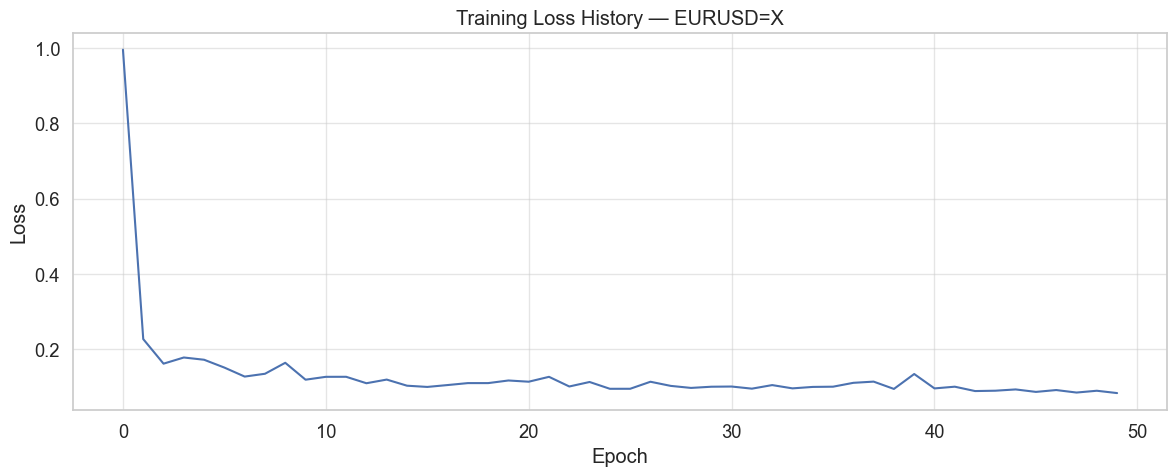


Training completed! Final loss: 0.082305


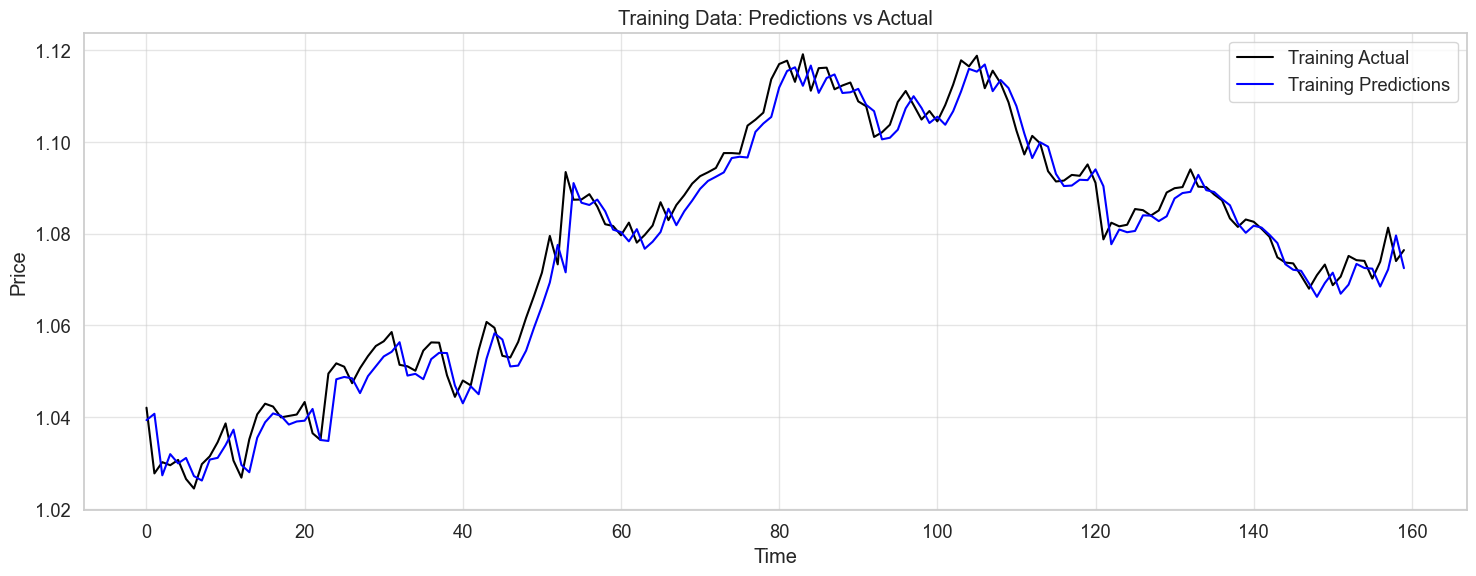

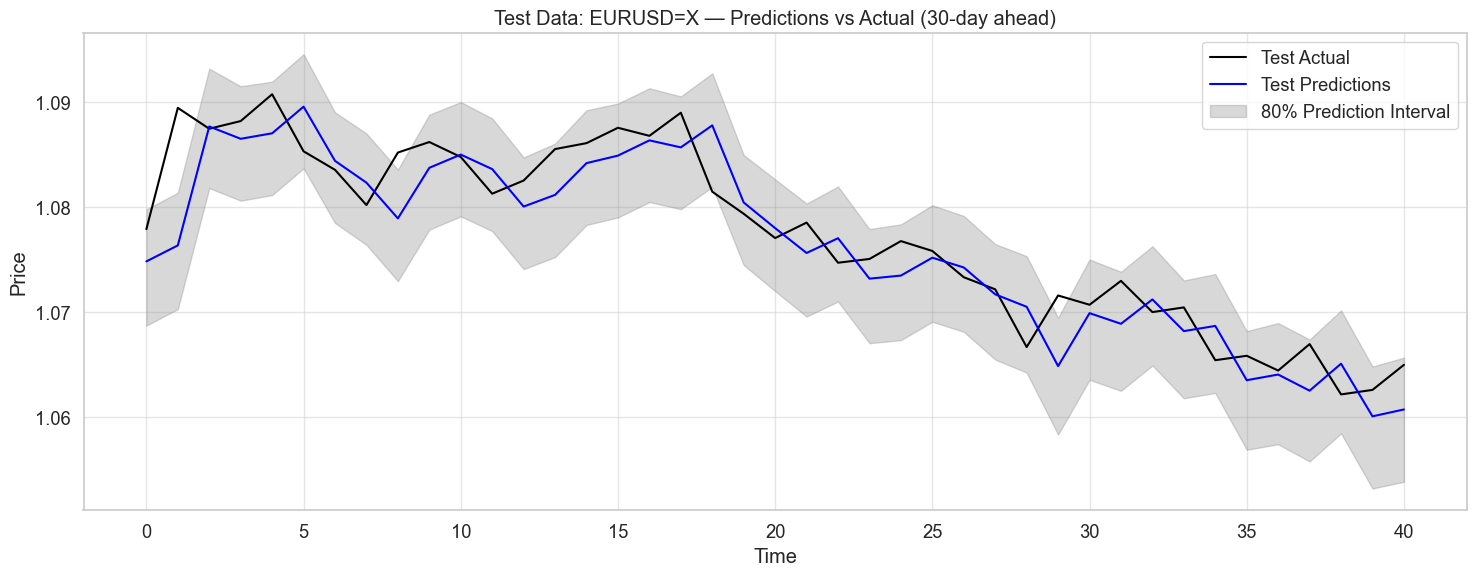


Test Set Metrics:
MAE: 0.00
RMSE: 0.00
MAPE: 0.26%
✅ Saved forecast to forecast_outputs/EURUSD=X.json
✅ Saved model to models/model_EURUSD=X.pt


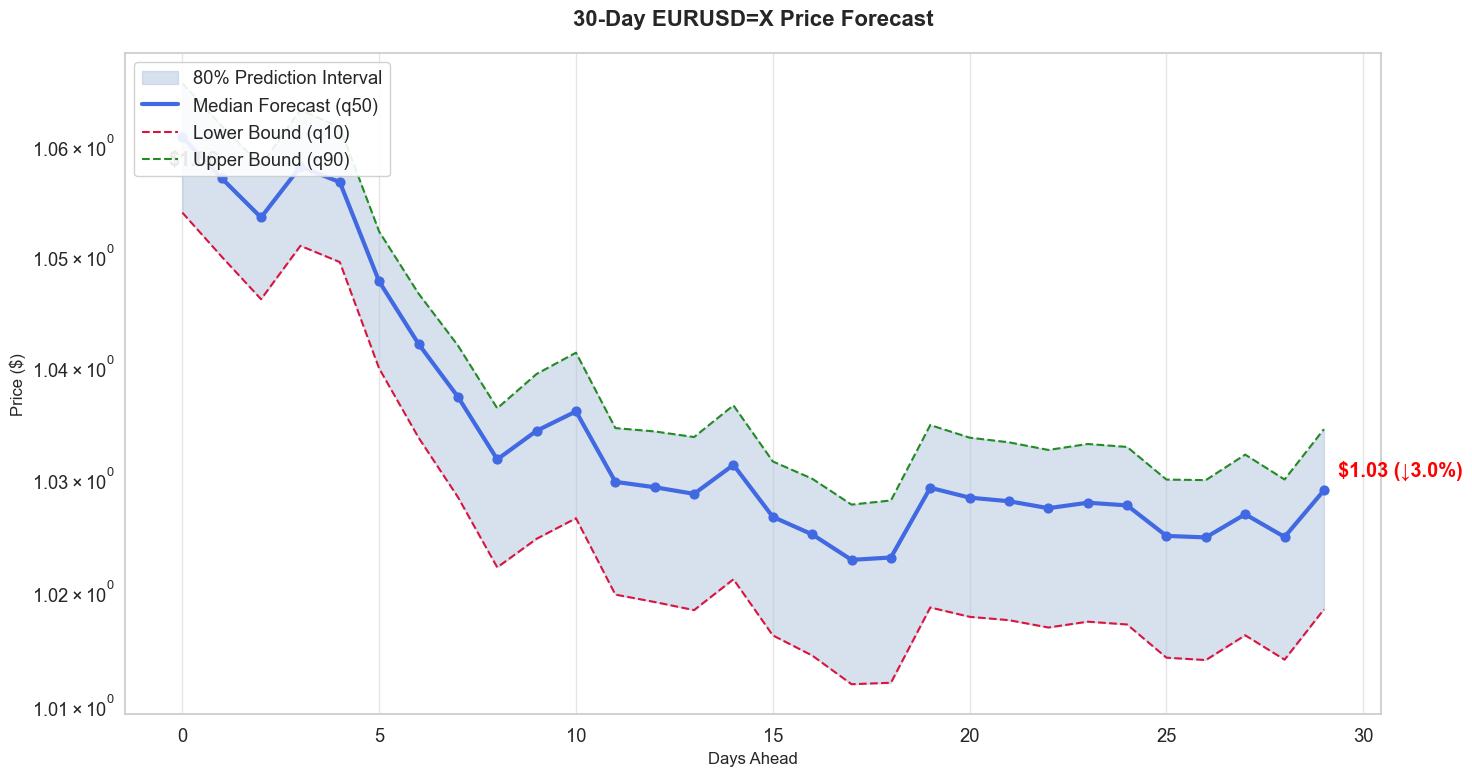

✅ Completed: EURUSD=X


In [31]:
def main():
    tickers = ["BTC-USD", "ETH-USD", "EURUSD=X"]

    for ticker in tickers:
        print(f"\n{'='*60}\n🏁 Running pipeline for {ticker}\n{'='*60}")

        # Download and preprocess data
        df = yf.Ticker(ticker).history(period="1y", interval="1d")
        df.reset_index(inplace=True)
        df = df[::-1]
        df["Price"] = df["Close"].astype(float)

        # Save historical data to local folder
        save_dir = r"C:\Users\Chico\OneDrive\Ambiente de Trabalho\Quant LSTM\yf data"
        os.makedirs(save_dir, exist_ok=True)

        filename = os.path.join(save_dir, f"{ticker.replace('/', '_')}.csv")
        df.to_csv(filename, index=False)
        print(f"📁 Saved historical data to: {filename}")


        # Run Optuna hyperparameter search
        best_params = run_hyperparameter_optimization(df, ticker, n_trials=20)

        lookback = best_params["lookback"]
        hidden_size = best_params["hidden_size"]
        num_stacked_layers = best_params["num_layers"]
        dropout = best_params["dropout"]
        learning_rate = best_params["learning_rate"]
        batch_size = best_params["batch_size"]

        # Prepare data using best hyperparameters
        X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(
            df, lookback=lookback, horizon=horizon, scaler_type="robust"
        )

        train_dataset = TSData(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        model = QuantileLSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_stacked_layers,
            dropout=dropout,
            num_quantiles=len(quantiles)
        ).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

        model = train_model(model, train_loader, optimizer, num_epochs=num_epochs, device=device, ticker=ticker)

        results = evaluate_quantile_predictions(model, X_train, y_train, X_test, y_test, scaler, lookback, ticker)
        X_last_window = X_test[-1].unsqueeze(0)
        forecast = forecast_next_days(model, X_last_window, scaler, lookback, horizon, quantiles)

        # Save forecast as JSON with Day column
        os.makedirs("forecast_outputs", exist_ok=True)
        forecast_df = pd.DataFrame(forecast)
        forecast_df["Day"] = list(range(1, horizon + 1))
        forecast_df = forecast_df[["Day", "q10", "q50", "q90"]]  # reordering
        forecast_df.to_json(f"forecast_outputs/{ticker.replace('/', '_')}.json", orient="records", indent=4)
        print(f"✅ Saved forecast to forecast_outputs/{ticker.replace('/', '_')}.json")

        # Save model
        os.makedirs("models", exist_ok=True)
        torch.save(model.state_dict(), f"models/model_{ticker.replace('/', '_')}.pt")
        print(f"✅ Saved model to models/model_{ticker.replace('/', '_')}.pt")

        # Plot forecast
        plot_forecast(forecast, ticker)

        print(f"✅ Completed: {ticker}")

if __name__ == "__main__":
    main()
